# **Pool detection - Exploratory Data Analysis**

Dataset obtenido de https://github.com/yacine-benbaccar/Pool-Detection

## **Librerías**

In [86]:
#%pip install scipy scikit-image scikit-learn numpy pandas matplotlib seaborn

In [87]:
import os
import random

from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import exposure

from skimage.feature import graycomatrix, graycoprops
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

## **Constantes**

In [88]:
DATA_DIR = os.path.join('..', 'data')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALIDATION_DIR = os.path.join(DATA_DIR, 'validation')
FEATURES_DIR = os.path.join(DATA_DIR, 'features')
POSITIVE_LABEL = 'pools'
NEGATIVE_LABEL = 'no_pools'

La siguiente celda puede ser modificada para obtener resultados personalizados:

In [89]:
GABOR = False
USE_CACHE = False 
PLOT_RESULTS = True
SEED = 2
random.seed(SEED)

### **Análisis del Conjunto de Datos**

In [90]:
train_filenames = [] 
for label in os.listdir(TRAIN_DIR):
    images = os.listdir(os.path.join(TRAIN_DIR, label))
    train_filenames.extend((image, label) for image in images)
    
validation_filenames = []
for label in os.listdir(VALIDATION_DIR):
    images = os.listdir(os.path.join(VALIDATION_DIR, label))
    validation_filenames.extend((image, label) for image in images)

**Tamaño de conjuntos**

In [91]:
train_filenames_length = len(train_filenames)
validation_filenames_length = len(validation_filenames)
positive_length = len([x for x in train_filenames if x[1] == POSITIVE_LABEL])
negative_train_length = len([x for x in train_filenames if x[1] == NEGATIVE_LABEL])
positive_validation_length = len([x for x in validation_filenames if x[1] == POSITIVE_LABEL])
negative_validation_length = len([x for x in validation_filenames if x[1] == NEGATIVE_LABEL])
train_length_rate = train_filenames_length / (train_filenames_length + validation_filenames_length)

print('Porcentaje de imágenes de train:', train_length_rate); print()
print('Número de imágenes de train:', train_filenames_length)
print('Número de imágenes de validación:', validation_filenames_length); print()
print('Número de imágenes positivas en train:', positive_length)
print('Número de imágenes negativas en train:', negative_train_length); print()
print('Número de imágenes positivas en validación:', positive_validation_length)
print('Número de imágenes negativas en validación:', negative_validation_length)

Porcentaje de imágenes de train: 0.8846653671215075

Número de imágenes de train: 2723
Número de imágenes de validación: 355

Número de imágenes positivas en train: 1398
Número de imágenes negativas en train: 1325

Número de imágenes positivas en validación: 179
Número de imágenes negativas en validación: 176


**Tamaño de imágenes**

In [92]:
train_images = []
validation_images = []
images_dimensions = set()

for filename, label in train_filenames:
    image_dir = os.path.join(TRAIN_DIR, label, filename)
    image = plt.imread(image_dir)
    train_images.append((image_dir, image, label))
    images_dimensions.add(image.shape)
for filename, label in validation_filenames:
    image_dir = os.path.join(VALIDATION_DIR, label, filename)
    image = plt.imread(image_dir)
    validation_images.append((image_dir, image, label))
    images_dimensions.add(image.shape)

In [93]:
print('Cantidad de dimensiones de las imágenes:', len(images_dimensions))
print('Dimensiones de las imágenes:', images_dimensions)

Cantidad de dimensiones de las imágenes: 1
Dimensiones de las imágenes: {(50, 50, 3)}


**Reordenar datos**

In [94]:
random.shuffle(train_filenames)
random.shuffle(validation_filenames)

**Mostrar primeros datos**

In [95]:
def plot_image_samples(filenames, n_samples=4):
    _, ax = plt.subplots(2, n_samples//2, figsize=(20, 10))
    for i, (image, label) in enumerate(filenames):
        row_idx = 0 if i < n_samples//2 else 1
        col_idx = i if i < n_samples//2 else i - n_samples//2
        image_dir = os.path.join(TRAIN_DIR, label, image)
        ax[row_idx, col_idx].imshow(plt.imread(image_dir))
        ax[row_idx, col_idx].set_title(label)
        ax[row_idx, col_idx].axis('off')
    plt.tight_layout()

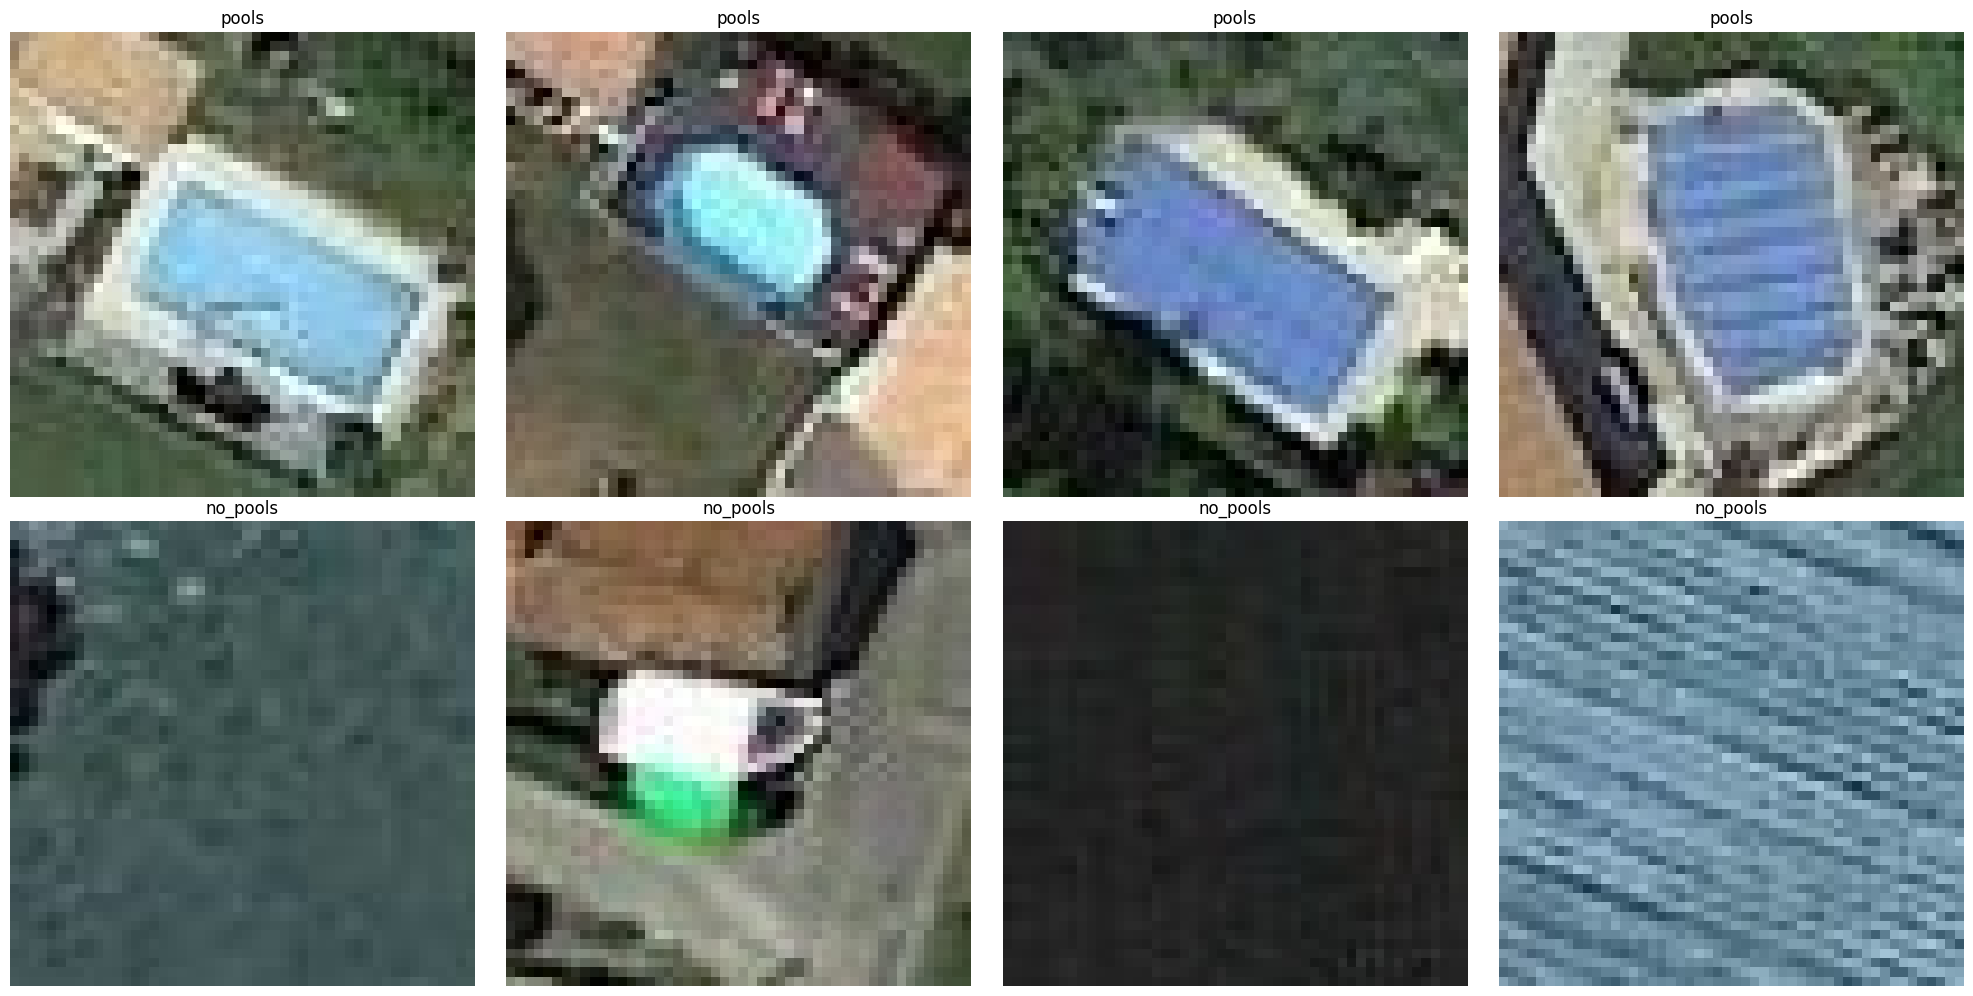

In [96]:
first_number = 8
positive_images_dirs = list(filter(lambda x: x[1] == POSITIVE_LABEL, train_filenames))[:first_number//2]
negative_images_dirs = list(filter(lambda x: x[1] == NEGATIVE_LABEL, train_filenames))[:first_number//2]
first_images = [*positive_images_dirs, *negative_images_dirs]

if PLOT_RESULTS:
    plot_image_samples(first_images, n_samples=first_number)

**Separar conjunto de validación**

In [97]:
dev_size = (len(validation_images) + len(train_images)) // 10
y_original_train = [x[2] for x in train_images]
train_images, dev_images = train_test_split(train_images, test_size=dev_size, random_state=SEED, stratify=y_original_train)

### **Aumentación de datos**

In [98]:
augmentation_functions = {
    'rotate': lambda image: rotate(image, random.randint(0, 360)),
    'noise': lambda image: random_noise(image),
    'gamma': lambda image: exposure.adjust_gamma(image, random.uniform(0.5, 1.5)),
    'gaussian': lambda image: gaussian(image),
}

def augment_images(
    images, 
    augment_rate=0.2,
    rotation_factor=0.05,
    noise_factor=0.025,
    gamma_factor=0.025,
    gaussian_factor=0.1,
):
    augmentation_rates = [rotation_factor, noise_factor, gamma_factor, gaussian_factor]
    rates = sum(augmentation_rates)
    if rates != augment_rate:
        print('Warning: Augment rate is not equal to sum of augmentation rates')
        gaussian_factor += augment_rate - rates

    augmented_images = []
    for (image_dir, image, label) in images:
        if random.random() < augment_rate:
            function = random.choices(
                list(augmentation_functions.keys()), 
                weights=[rotation_factor, noise_factor, gamma_factor, gaussian_factor]
            )[0]
            augmented_image = augmentation_functions[function](image)
            min_image, max_image = np.min(augmented_image), np.max(augmented_image)
            augmented_image = ((augmented_image - min_image) / (max_image - min_image)) * 255
            augmented_image = augmented_image.astype(np.uint8)
            augmented_images.append((image_dir, augmented_image, label, image))
    return augmented_images

In [99]:
augmented_train_images = augment_images(train_images)

f:\AlexisF\python\lib\site-packages\skimage\_shared\utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


In [100]:
def compare_augmented_images(augmented_images, showed_images=5):
    fig, ax = plt.subplots(2, showed_images, figsize=(12, 5))
    for idx, (_, image, label, original_image) in enumerate(augmented_images[:showed_images]):
        ax[0, idx].imshow(image)
        ax[1, idx].set_title(f'{label}')
        ax[0, idx].axis('off')

        ax[1, idx].imshow(original_image)
        ax[0, idx].set_title(f'Augmented')
        ax[1, idx].axis('off')
    plt.tight_layout()

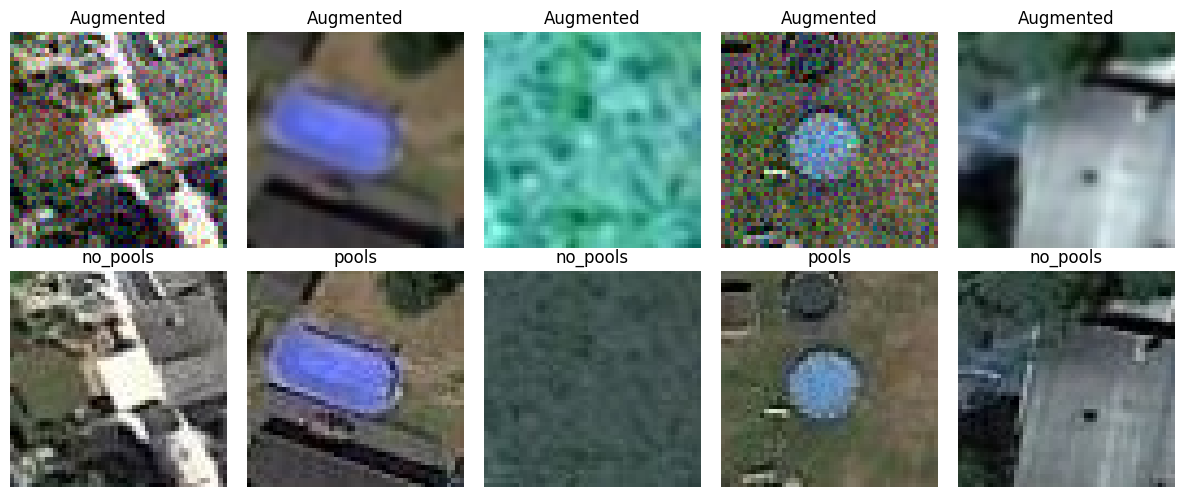

In [101]:
if PLOT_RESULTS:
    compare_augmented_images(augmented_train_images)

In [102]:
train_images = [*train_images, *[augmented_image[:3] for augmented_image in augmented_train_images]]

### **Features**

##### **Filtros de Gabor** (no utilizados)

In [103]:
# https://www.freedomvc.com/index.php/2021/10/16/gabor-filter-in-edge-detection/
def create_gaborfilter():
    filters = []
    num_filters = 16
    ksize = 35
    sigma = 3.0 
    lambd = 10.0
    gamma = 0.5
    psi = 0
    for theta in np.arange(0, np.pi, np.pi / num_filters):
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
        kern /= 1.0 * kern.sum()
        filters.append(kern)
    return filters

def apply_filter(img, filters):
    newimage = np.zeros_like(img)
    depth = -1
     
    for kern in filters:
        image_filter = cv2.filter2D(img, depth, kern)
        np.maximum(newimage, image_filter, newimage)
    return newimage

In [104]:
if GABOR:
    gfilters = create_gaborfilter()
    train_images = [(x[0], apply_filter(x[1], gfilters), x[2]) for x in train_images]
    dev_images = [(x[0], apply_filter(x[1], gfilters), x[2]) for x in dev_images]

In [105]:
if GABOR and PLOT_RESULTS:
    fig, ax = plt.subplots(2, 4, figsize=(20, 10))
    for i, (image_dir, image, label) in enumerate(train_images[:8]):
        row_idx = 0 if i < 4 else 1
        col_idx = i if i < 4 else i - 4
        ax[row_idx, col_idx].imshow(image)
        ax[row_idx, col_idx].set_title(label)
        ax[row_idx, col_idx].axis('off')

#### **Features de color**

In [106]:
def has_blue(img):
    w, h, _ = img.shape
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv_l = np.array([100, 150, 0])
    hsv_h = np.array([140, 255, 255])
    return cv2.inRange(hsv, hsv_l, hsv_h).any()

In [107]:
def create_color_features_df(images):
    features = []
    for image_dir, image, label in images:
        features.append((image_dir, 'has_blue', int(has_blue(image)), label))
    return pd.DataFrame(features, columns=['image_id', 'feature_name', 'feature_value', 'label'])

In [108]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'color_features.csv')):
    color_features_df = pd.read_csv(os.path.join(FEATURES_DIR, 'color_features.csv'))
    dev_color_features_df = pd.read_csv(os.path.join(FEATURES_DIR, 'dev_color_features.csv'))
else:
    color_features_df = create_color_features_df(train_images)
    color_features_df.to_csv(os.path.join(FEATURES_DIR, 'color_features.csv'), index=False)
    dev_color_features_df = create_color_features_df(dev_images)
    dev_color_features_df.to_csv(os.path.join(FEATURES_DIR, 'dev_color_features.csv'), index=False)


#### **Features a nivel de canal**

**Medidas de tendencia central**

In [109]:
def calculate_mean(image_gray: np.ndarray):
    return image_gray.mean()

def calculate_median(image_gray: np.ndarray):
    return np.median(image_gray)

def calculate_mode(image_gray: np.ndarray):
    counts = [0] * 256
    for row in image_gray:
        for pixel in row:
            counts[pixel] += 1
    return np.argmax(counts)

**Medidas de dispersión**

In [110]:
def calculate_std(image_gray: np.ndarray):
    return image_gray.std()

**Cuantiles**

In [111]:
def calculate_min(image_gray: np.ndarray):
    return image_gray.min()

def calculate_max(image_gray: np.ndarray):
    return image_gray.max()

def calculate_range(image_gray: np.ndarray):
    return image_gray.max() - image_gray.min()

def calculate_quantile(image_gray: np.ndarray, q: float):
    bin_count = 256
    hist, bin_edges = np.histogram(image_gray, bins=bin_count)
    cum_values = np.cumsum(hist * np.diff(bin_edges))
    quantile = np.interp(q * 100, cum_values, bin_edges[:-1])
    return quantile

def calculate_iqr(image_gray: np.ndarray):
    return calculate_quantile(image_gray, 0.75) - calculate_quantile(image_gray, 0.25)

**Probabilidad**

In [112]:
def calculate_entropy(image_gray: np.ndarray):
    hist, _ = np.histogram(image_gray, bins=256)
    hist = hist[hist != 0]
    prob = hist / hist.sum()
    return -np.sum(prob * np.log2(prob)) / np.log2(len(prob))

def calculate_skewness(image_gray: np.ndarray):
    return stats.skew(image_gray, axis=None)

def calculate_kurtosis(image_gray: np.ndarray):
    return stats.kurtosis(image_gray, axis=None)

In [113]:
model_channel_feature_functions = {
    'mean': calculate_mean,
    'std': calculate_std,
    'median': calculate_median,
    'mode': calculate_mode,
    'min': calculate_min,
    'max': calculate_max,
    'range': calculate_range,
    'skewness': calculate_skewness,
    'kurtosis': calculate_kurtosis,
    'entropy': calculate_entropy,
    'quantile_0.25': lambda img: calculate_quantile(img, q=0.25),
    'quantile_0.75': lambda img: calculate_quantile(img, q=0.75),
    'iqr': calculate_iqr,
}

In [114]:
def create_channel_feature_df(images, model_feature_functions, include_grayscale=True):
    channels = ['red', 'green', 'blue'] + (['grayscale'] if include_grayscale else [])
    pixels_df = {'image_id': [], 'feature_name': [], 'feature_value': [], 'label': [], 'channel': []}

    for id, image, label in images:
        for feature_name, feature_function in model_feature_functions.items():
            for chnl in range(3):
                pixels_df['image_id'].append(id)
                pixels_df['feature_value'].append(feature_function(image[:, :, chnl]))
                pixels_df['feature_name'].append(feature_name)
                pixels_df['channel'].append(channels[chnl])
                pixels_df['label'].append(label)

            if include_grayscale:
                pixels_df['image_id'].append(id)
                averaged_image = np.clip(image.mean(axis=2).astype(int), 0, 255)
                pixels_df['feature_value'].append(feature_function(averaged_image))
                pixels_df['feature_name'].append(feature_name)
                pixels_df['channel'].append('grayscale')
                pixels_df['label'].append(label)

    df = pd.DataFrame(pixels_df)
    df['feature_value'] = df['feature_value'].astype(float)
    return df

In [115]:
def scale_feature_df(channel_feature_df: pd.DataFrame):
    channel_feature_df = channel_feature_df.copy()
    for feature_name in channel_feature_df['feature_name'].unique():
        feature_values = channel_feature_df[channel_feature_df['feature_name'] == feature_name]['feature_value']
        current_features_max = feature_values.max()
        current_features_min = feature_values.min()
        feature_values = (feature_values - current_features_min) / (current_features_max - current_features_min)
        channel_feature_df.loc[channel_feature_df['feature_name'] == feature_name, 'feature_value'] = feature_values
    return channel_feature_df

In [116]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'channel_feature_df.csv')):
    channel_feature_df = pd.read_csv(os.path.join(FEATURES_DIR, 'channel_feature_df.csv'))
    dev_channel_feature_df = pd.read_csv(os.path.join(FEATURES_DIR, 'dev_channel_feature_df.csv'))
else:
    channel_feature_df = create_channel_feature_df(train_images, model_channel_feature_functions)
    channel_feature_df.to_csv(os.path.join(FEATURES_DIR, 'channel_feature_df.csv'), index=False)
    dev_channel_feature_df = create_channel_feature_df(dev_images, model_channel_feature_functions)
    dev_channel_feature_df.to_csv(os.path.join(FEATURES_DIR, 'dev_channel_feature_df.csv'), index=False)

#### **Visualización de Datos**

##### **Nivel de azul según HSV**

<AxesSubplot: xlabel='feature_value', ylabel='feature_name'>

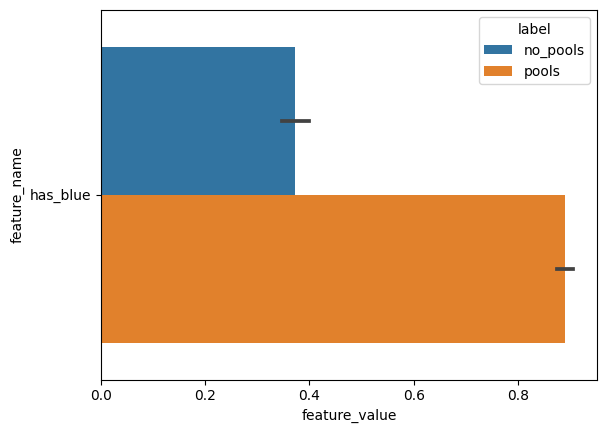

In [117]:
sns.barplot(x='feature_value', hue='label', data=color_features_df, y='feature_name')

##### **Separando por canal**

**Distribución de features (nivel general)**

In [118]:
def plot_histogram_features_violinplot(feature_df: pd.DataFrame):
    _, ax = plt.subplots(nrows=len(feature_df['channel'].unique()), figsize=(20, 20))
    for i, channel in enumerate(feature_df['channel'].unique()):
        current_feature_df = feature_df[feature_df['channel'] == channel]
        scaled_feature_df = scale_feature_df(current_feature_df)
        sns.violinplot(data=scaled_feature_df, x='feature_name', y='feature_value', hue='label', ax=ax[i])
        ax[i].legend(fontsize=10)
        ax[i].set_title(channel)
        plt.tight_layout()

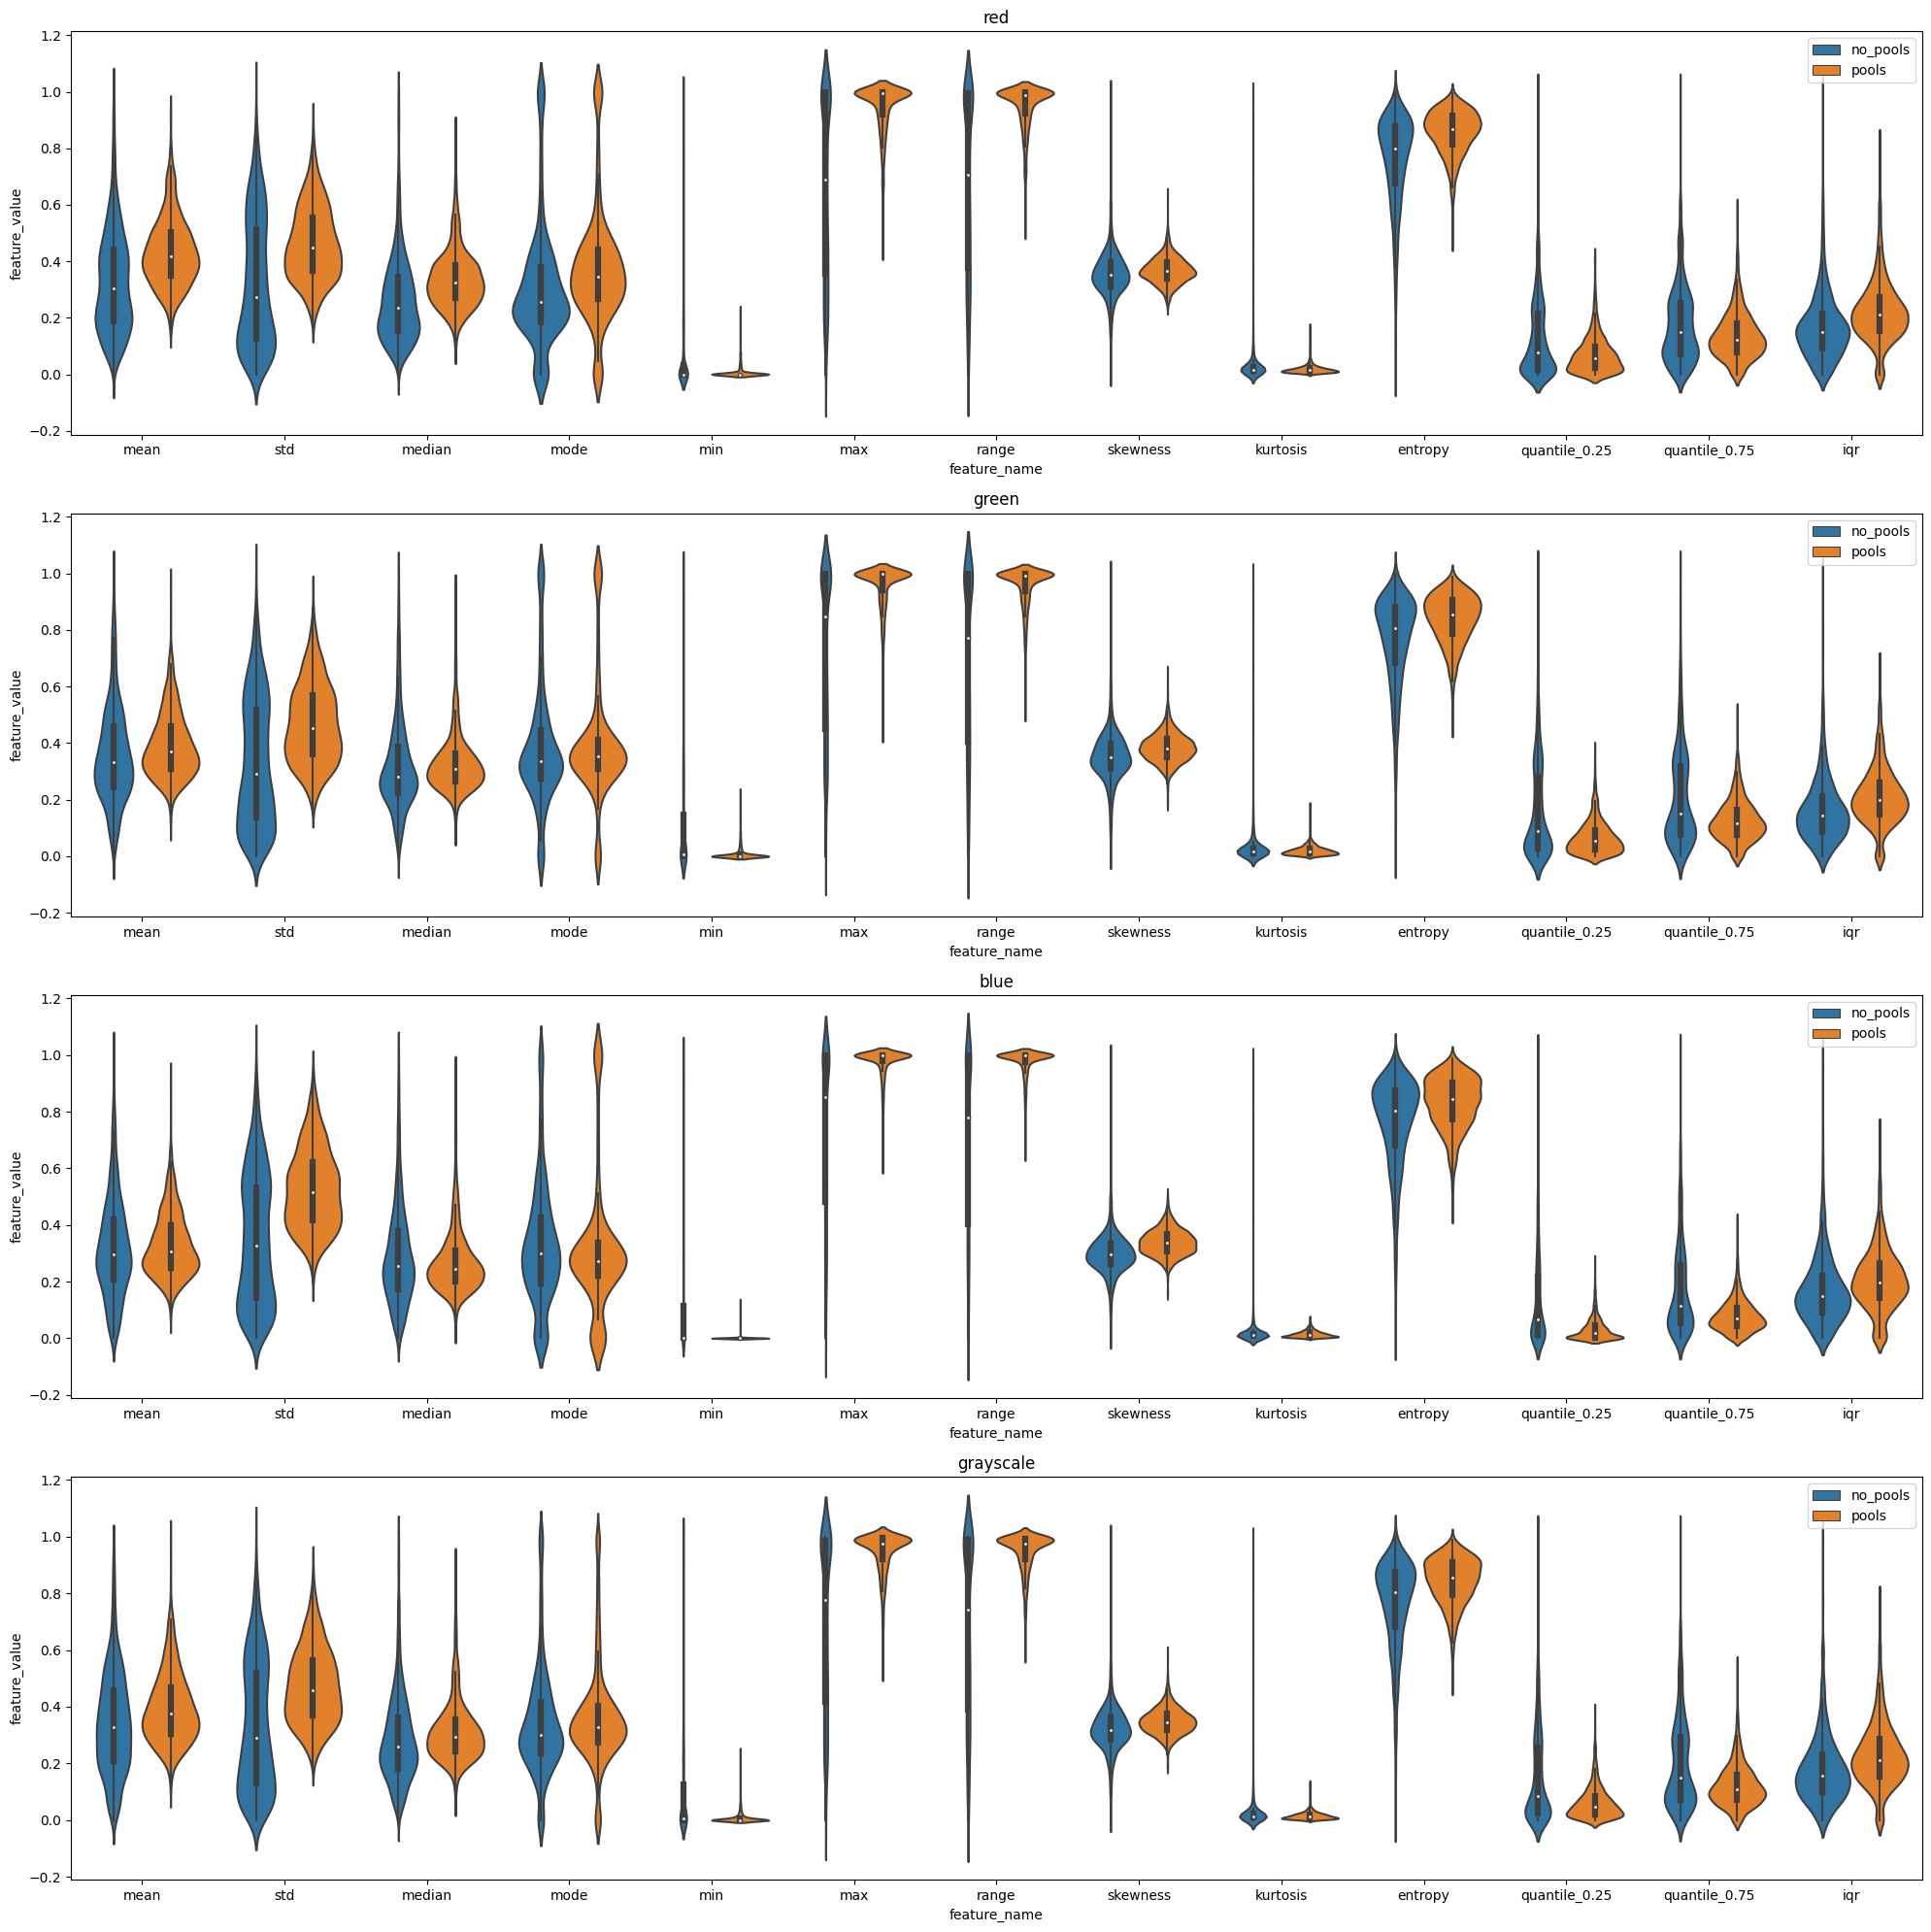

In [119]:
if PLOT_RESULTS:
    plot_histogram_features_violinplot(channel_feature_df)

**Distribución de features (nivel individual)**

In [120]:
def plot_channel_feature_df(pixels_df, color='red', secondary_color='blue', width=None, height=None):
    facet_grid = sns.displot(pixels_df, x='feature_value', hue='label', row='feature_name', col='channel', fill=True, palette=[secondary_color, color], kind='kde')
    facet_grid.fig.set_figwidth(width) if width else None
    facet_grid.fig.set_figheight(height) if height else None
    plt.legend(fontsize=10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

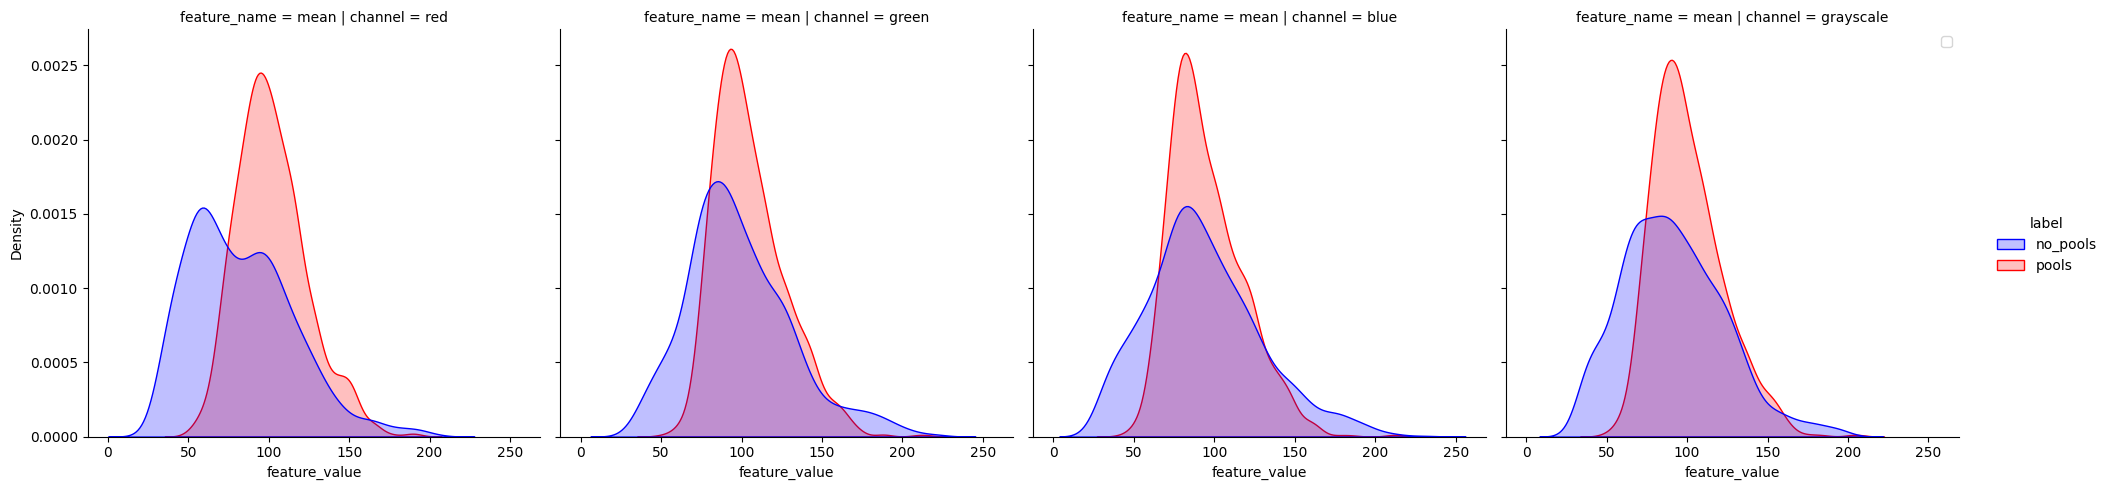

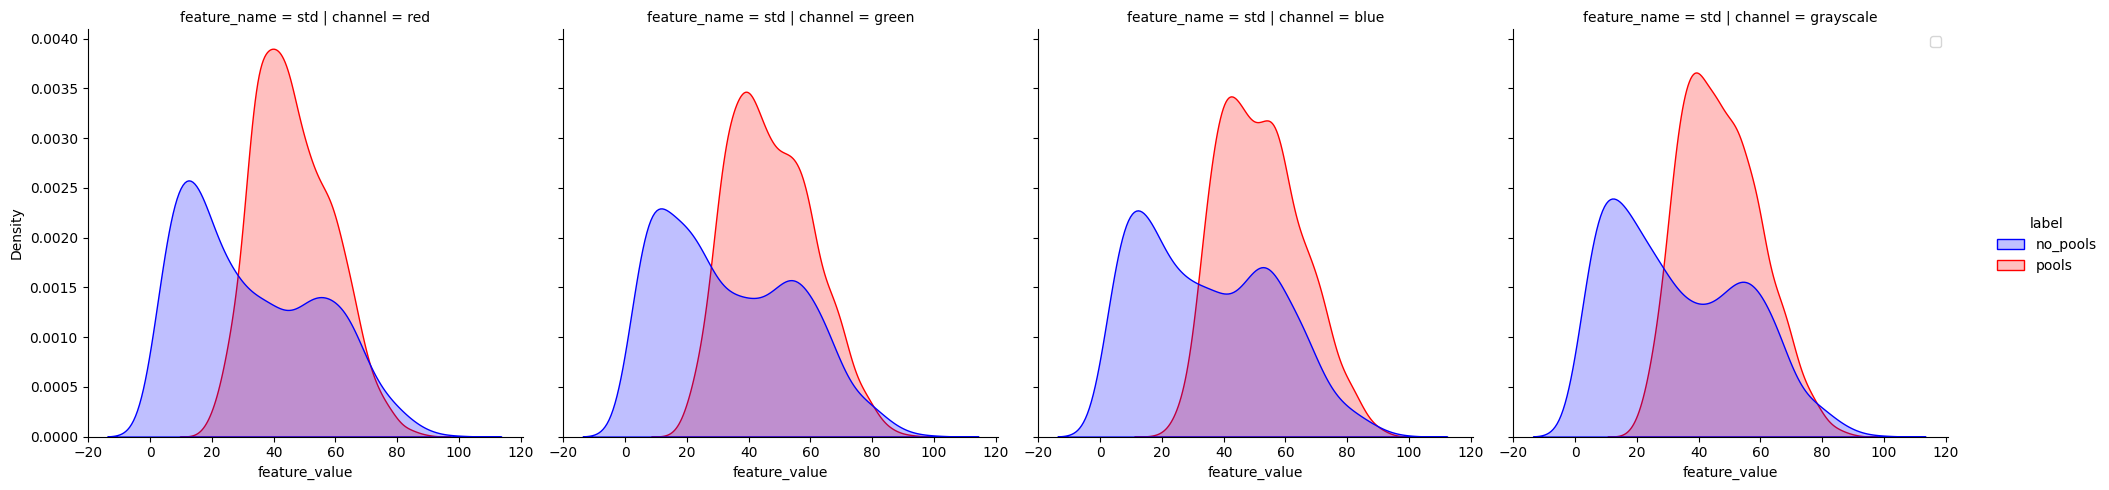

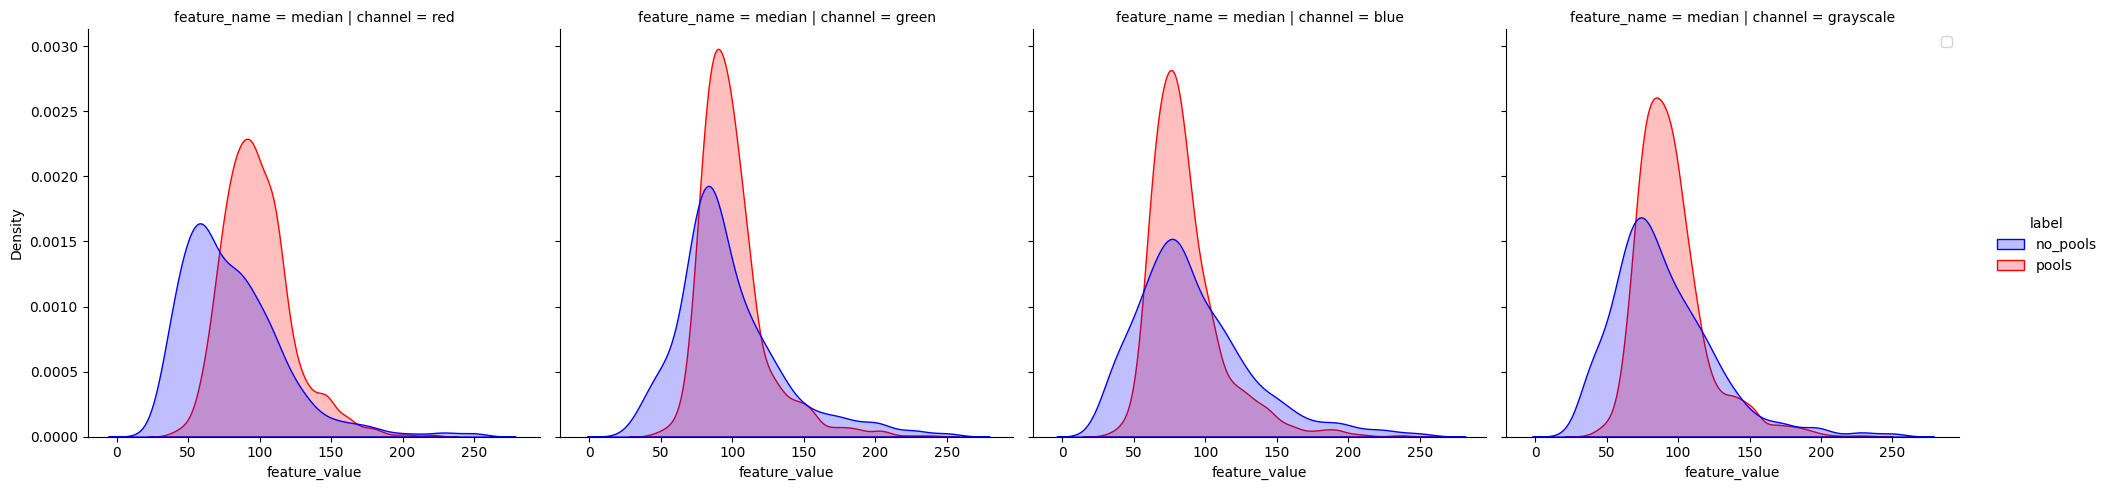

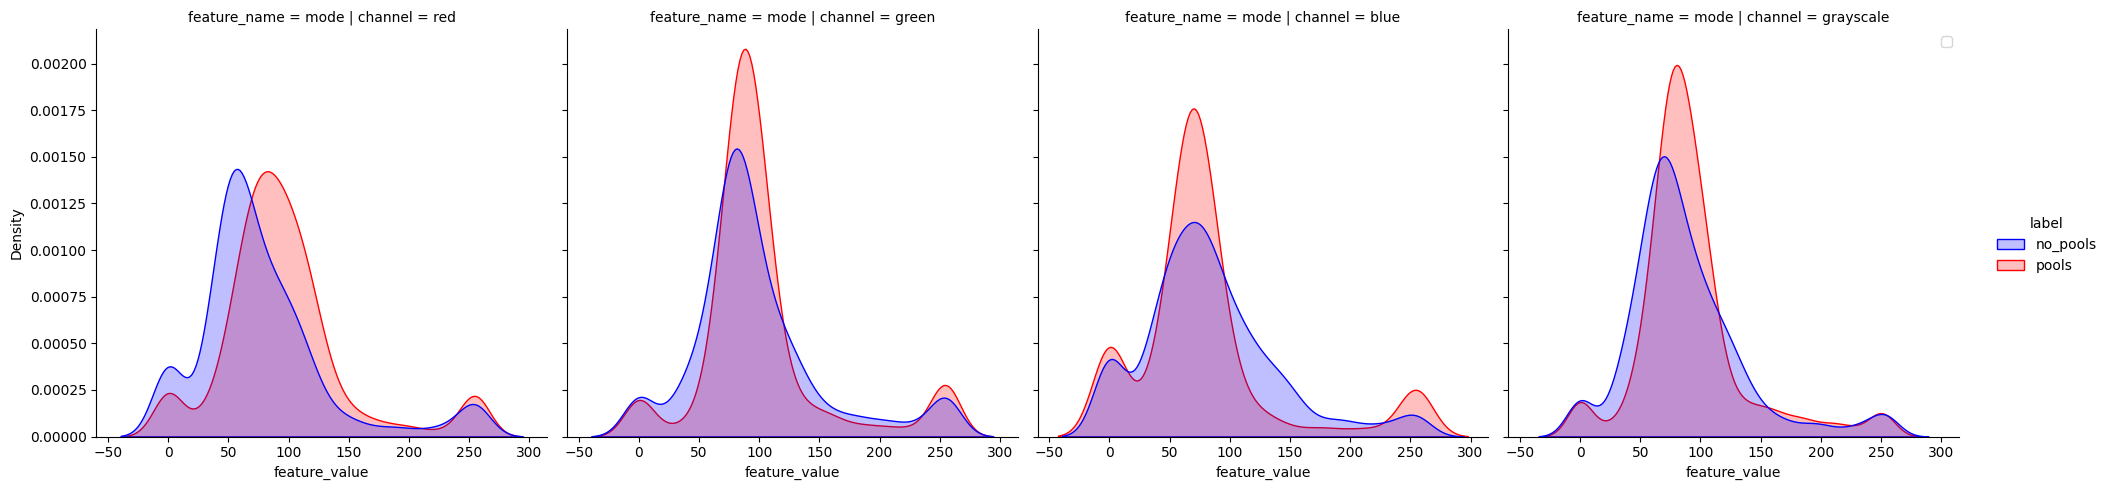

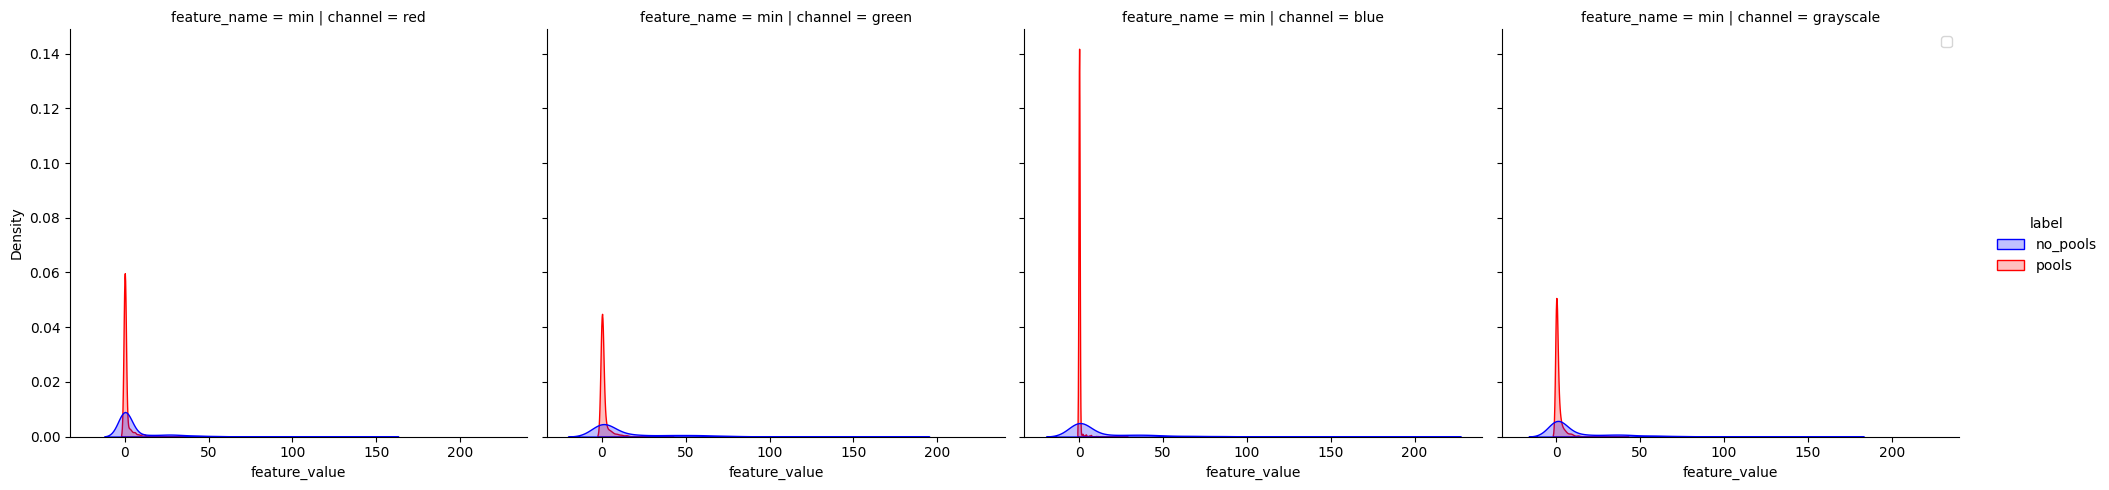

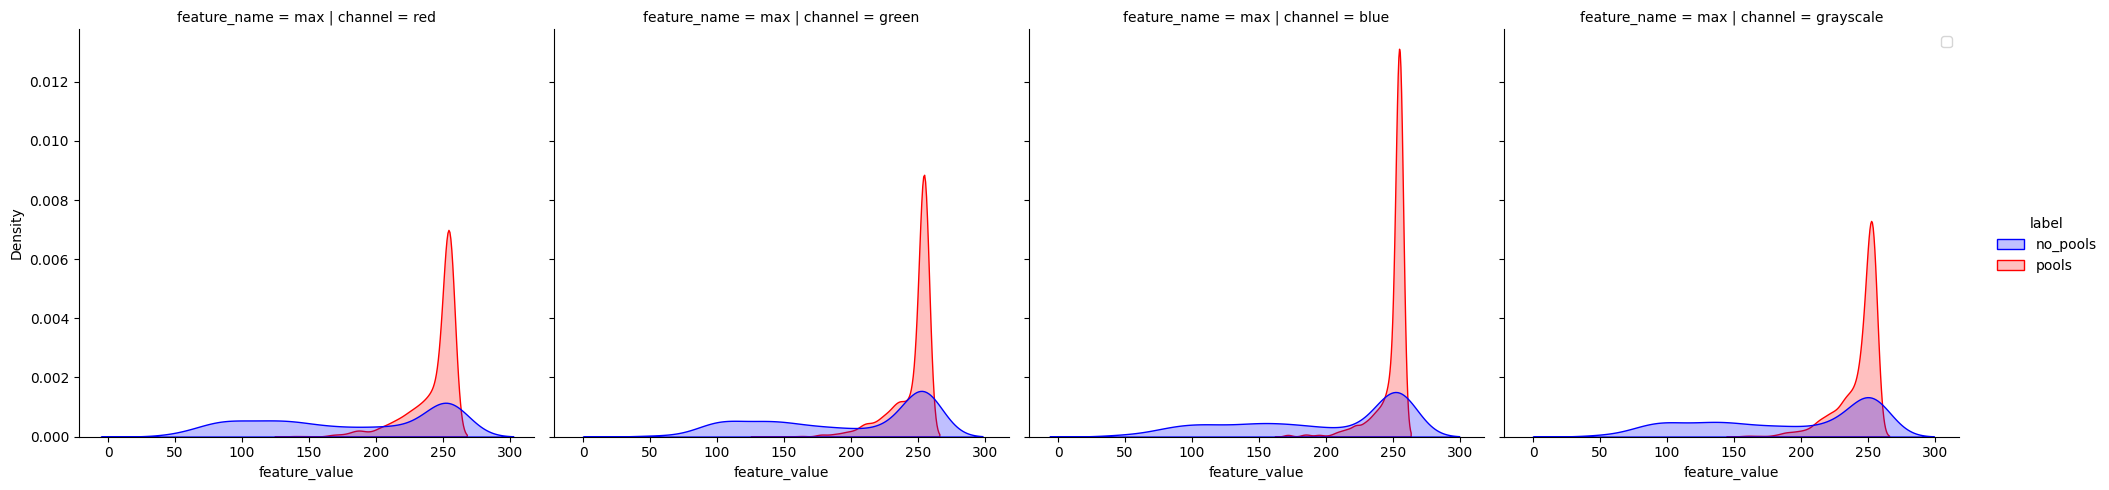

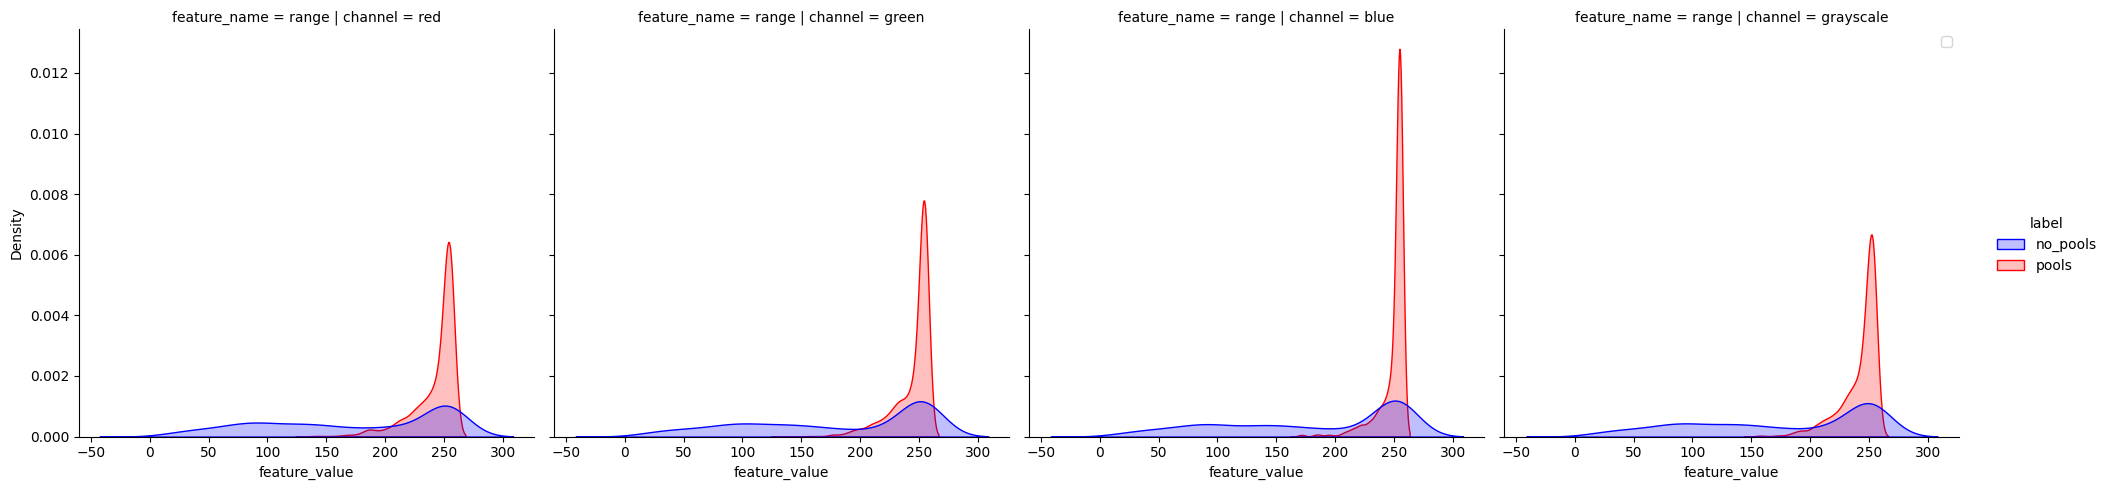

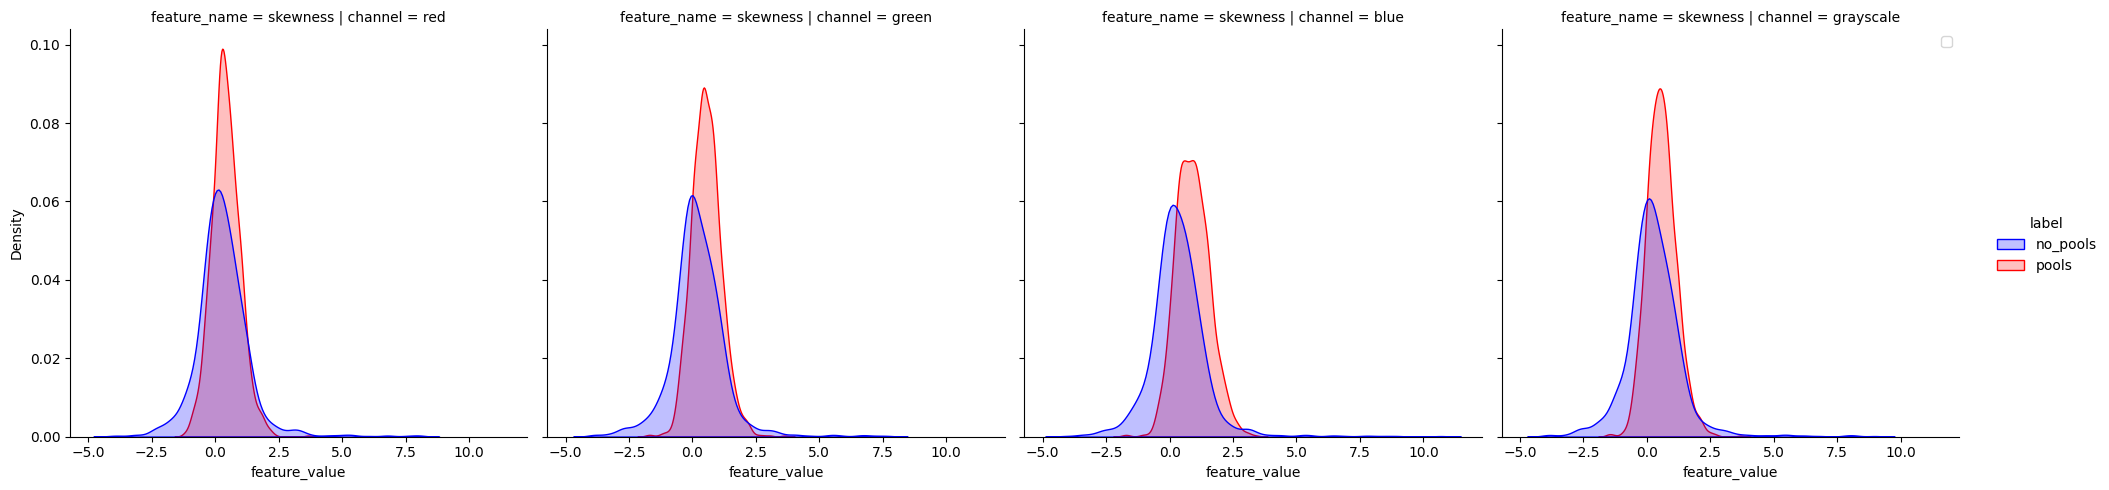

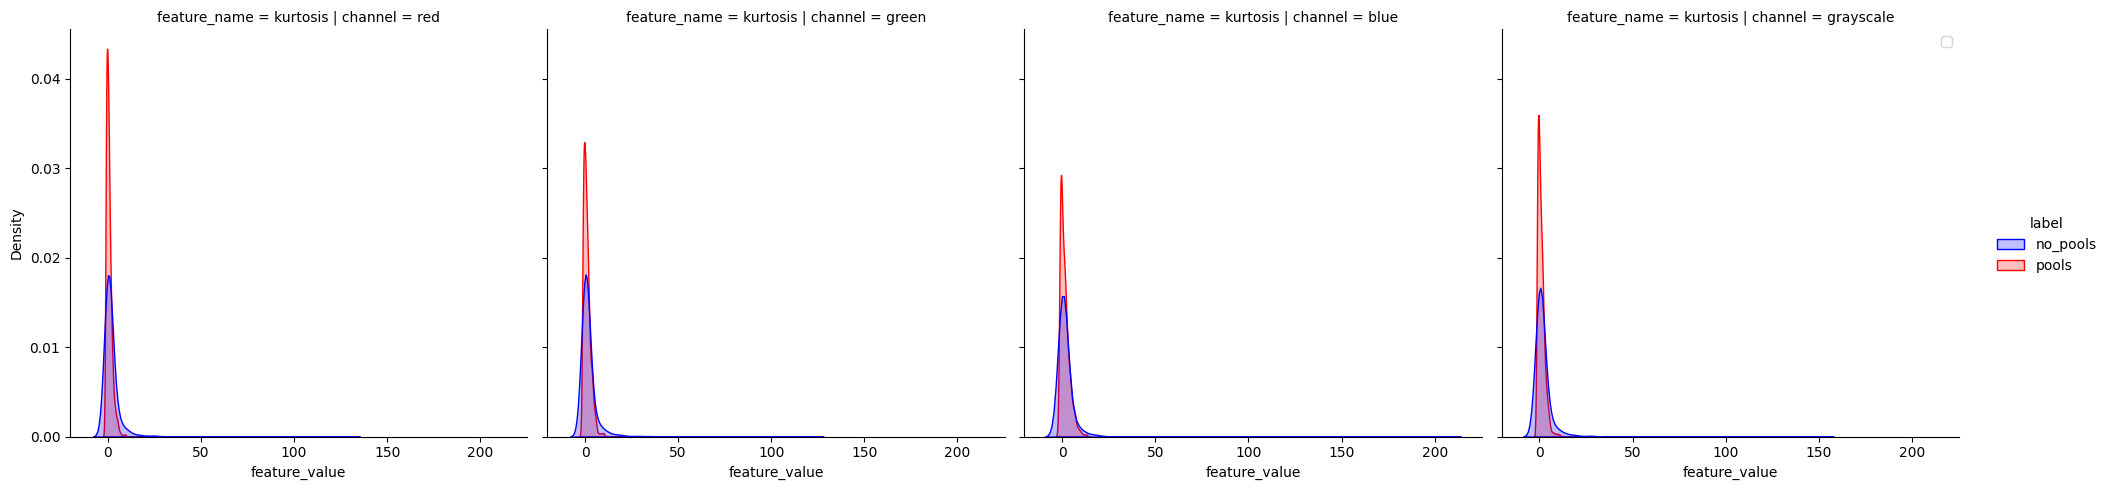

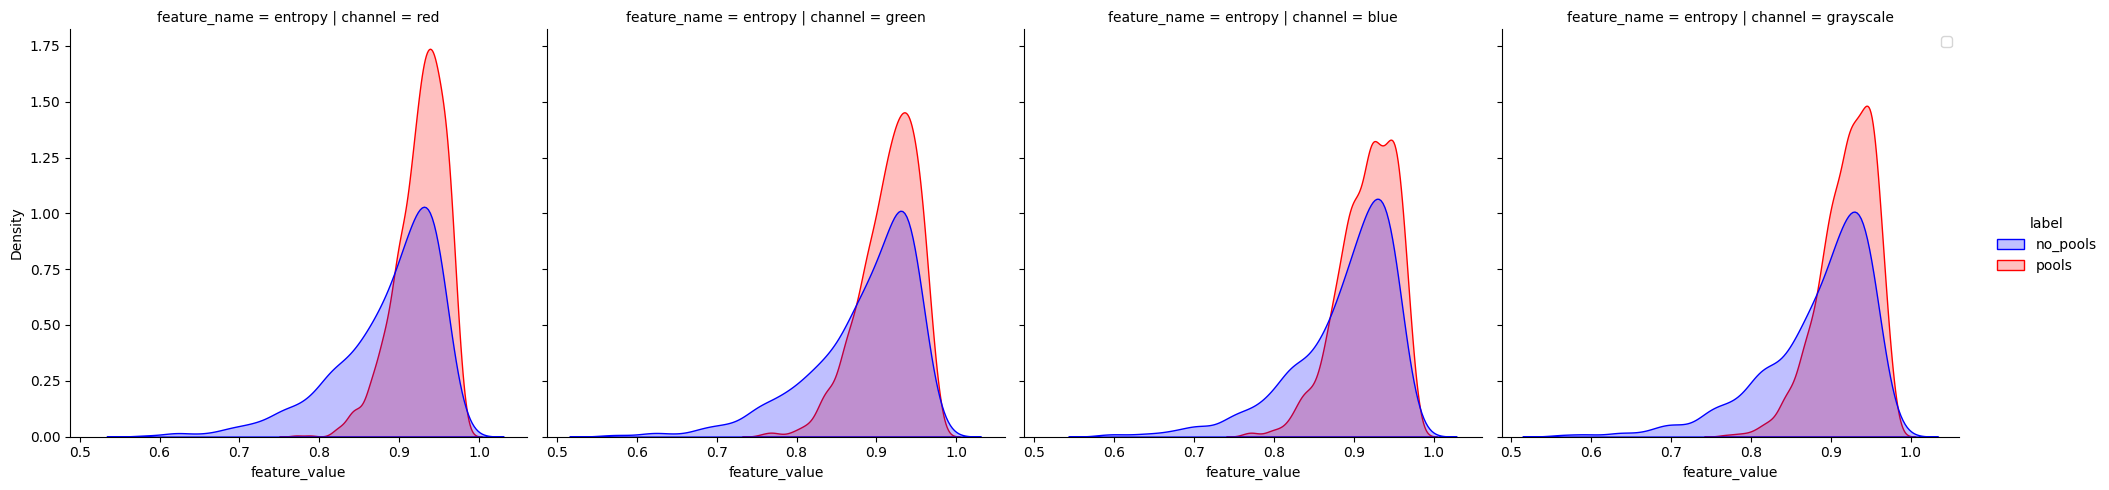

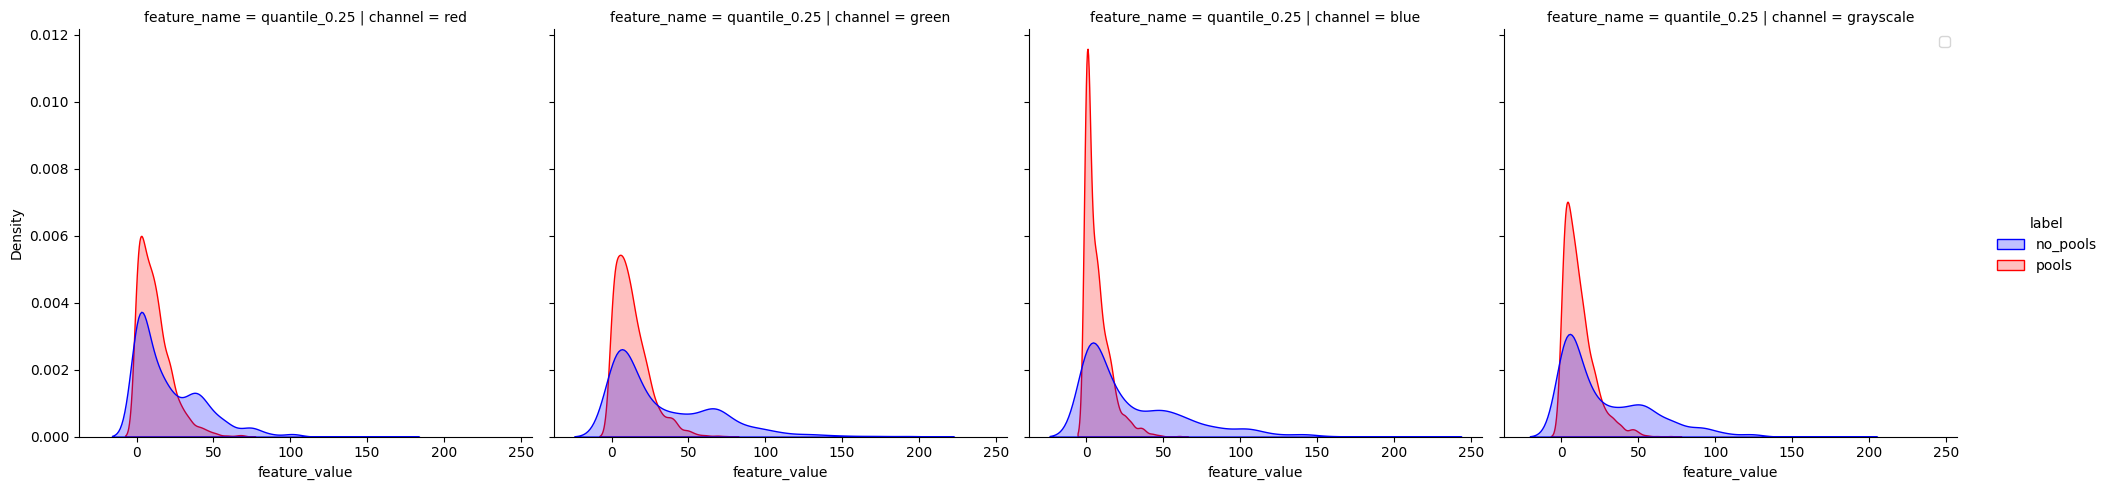

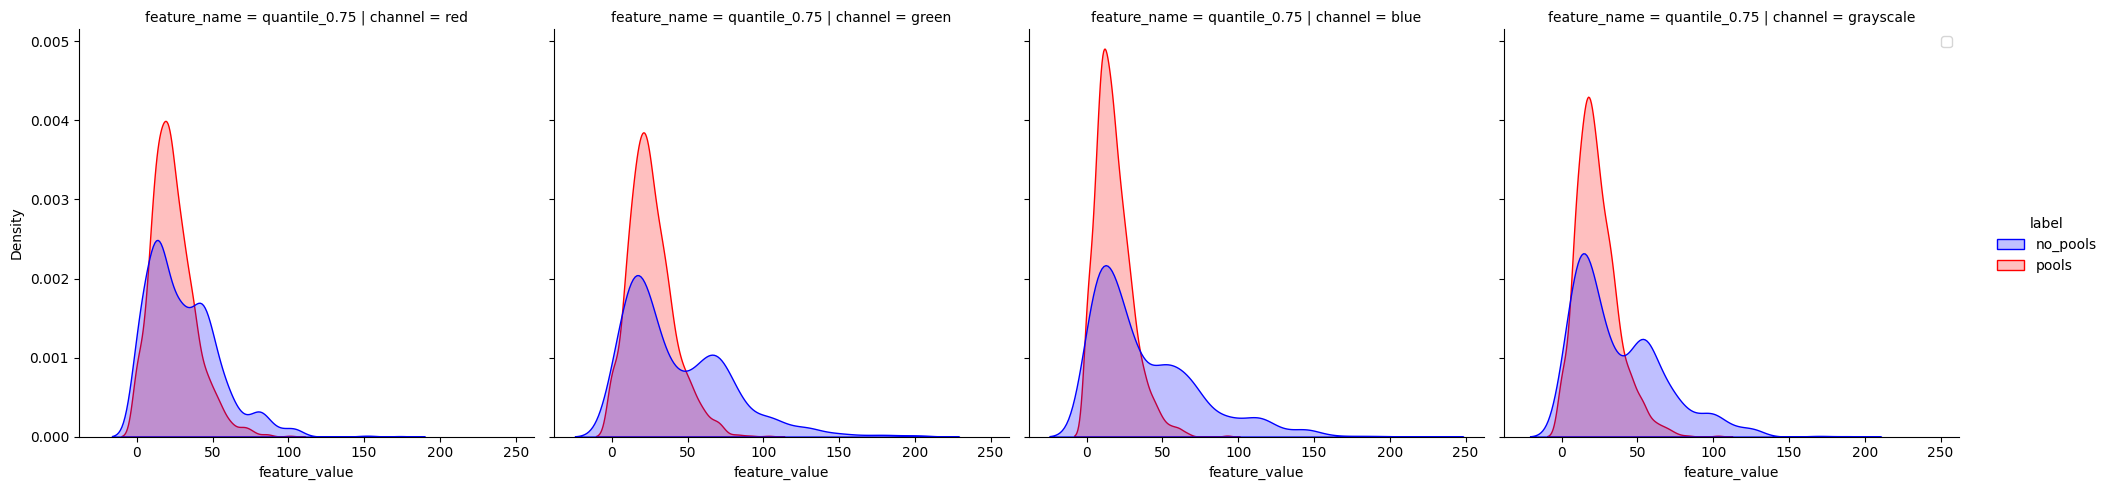

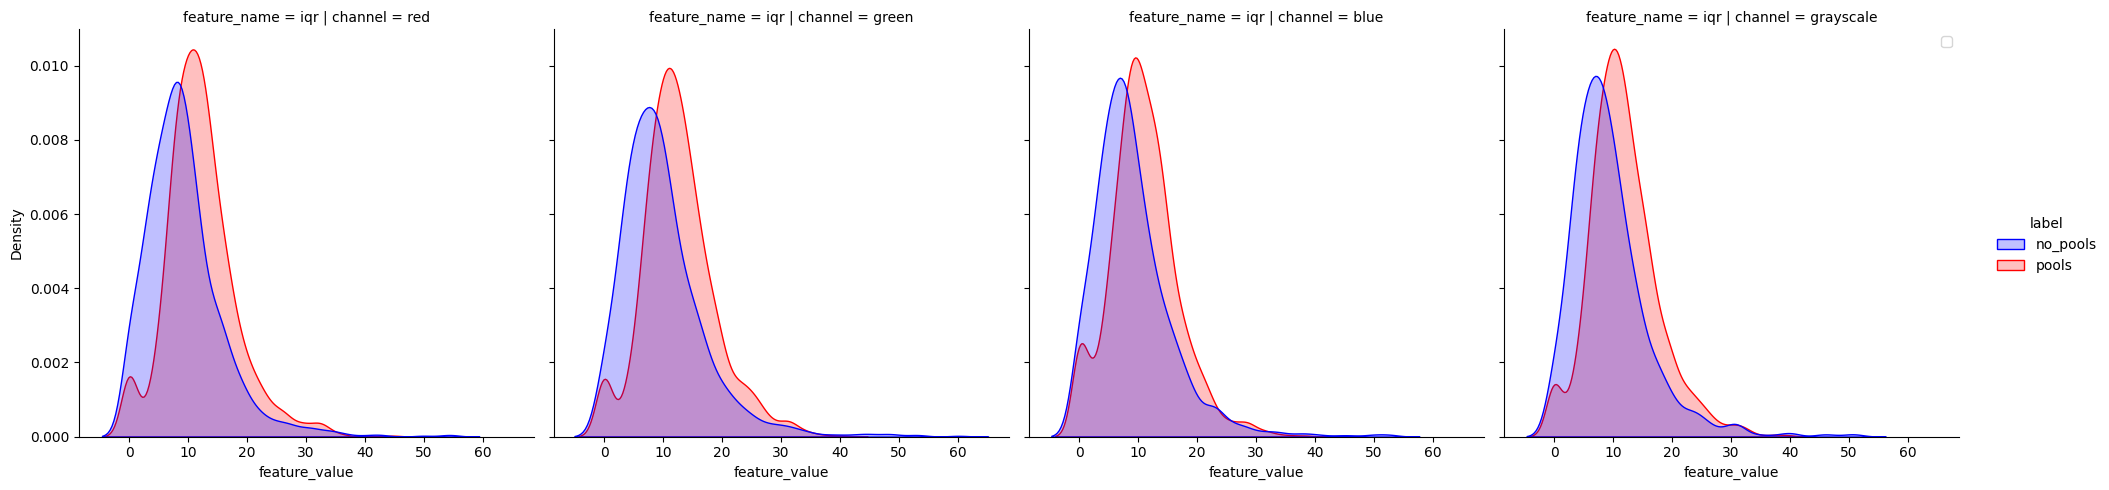

In [121]:
if PLOT_RESULTS:
    for feature_name in model_channel_feature_functions.keys():
        current_feature_df = channel_feature_df[channel_feature_df['feature_name'] == feature_name]
        plot_channel_feature_df(current_feature_df, color='red', secondary_color='blue')

##### **Features de histograma**

In [122]:
def calculate_mean_histogram(histogram: np.ndarray, numBins: int):
    return np.sum((np.arange(numBins) / numBins) * histogram)

def calculate_std_histogram(histogram: np.ndarray, numBins: int):
    mean = calculate_mean_histogram(histogram, numBins)
    return np.sqrt(np.sum(((np.arange(numBins) / numBins) - mean) ** 2 * histogram))

def calculate_median_histogram(histogram: np.ndarray, _: int):
    cumsum = np.cumsum(histogram)
    return np.argmax(cumsum >= cumsum[-1] / 2)

def calculate_mode_histogram(histogram: np.ndarray, _: int):
    return np.argmax(histogram)

def calculate_min_histogram(histogram: np.ndarray, _: int):
    return np.argmin(histogram)

def calculate_max_histogram(histogram: np.ndarray, _: int):
    return np.argmax(histogram)

def calculate_range_histogram(histogram: np.ndarray, _: int):
    return np.argmax(histogram) - np.argmin(histogram)

def calculate_quantile_histogram(histogram: np.ndarray, numBins: int, q: float):
    cum_values = np.cumsum(histogram)
    quantile = np.interp(q * 100, cum_values, np.arange(numBins))
    return quantile

def calculate_iqr_histogram(histogram: np.ndarray, numBins: int):
    return calculate_quantile_histogram(histogram, numBins, q=0.75) - calculate_quantile_histogram(histogram, numBins, q=0.25)

def calculate_skewness_histogram(histogram: np.ndarray, numBins: int):
    mean = calculate_mean_histogram(histogram, numBins)
    skewness = np.sum(((histogram - mean)**3) * histogram)
    return skewness

def calculate_kurtosis_histogram(histogram: np.ndarray, numBins: int):
    mean = calculate_mean_histogram(histogram, numBins)
    kurtosis = np.sum(((histogram - mean)**4) * histogram)
    return kurtosis

def calculate_uniformity_histogram(histogram: np.ndarray, _: int):
    return np.sum(histogram ** 2)

def calculate_entropy_histogram(histogram: np.ndarray, numBins: int):
    entropy = -np.sum(histogram * np.log2(histogram + 1e-12)) / np.log2(numBins)
    return entropy

def calculate_R_histogram(histogram: np.ndarray, _: int):
    R = 1 - 1 / (1 + np.std(histogram)**2)
    return R

In [123]:
model_histogram_feature_functions = {
    'mean': calculate_mean_histogram,
    'std': calculate_std_histogram,
    'median': calculate_median_histogram,
    'mode': calculate_mode_histogram,
    'min': calculate_min_histogram,
    'max': calculate_max_histogram,
    'range': calculate_range_histogram,
    'skewness': calculate_skewness_histogram,
    'kurtosis': calculate_kurtosis_histogram,
    'uniformity': calculate_uniformity_histogram,
    'entropy': calculate_entropy_histogram,
    'R': calculate_R_histogram,
}

In [124]:
def to_grayscale(images: list[tuple]):
    return [(
        id, 
        np.clip(image.mean(axis=2).astype(int), 0, 255), 
        label
    ) for id, image, label in images]

def to_histogram(image_gray: np.ndarray, bins: int = 256):
    hist, _ = np.histogram(image_gray, bins=bins, density=True)
    return hist

In [125]:
def create_histogram_features_df(images: list[tuple], model_histogram_feature_functions: dict, bins=256):
    pixels_df = {'image_id': [], 'feature_name': [], 'feature_value': [], 'label': []}
    grayscale_images = to_grayscale(images)

    for id, image, label in grayscale_images:
        image_histogram = to_histogram(image, bins=bins)

        for feature_name, feature_function in model_histogram_feature_functions.items():
            pixels_df['image_id'].append(id)
            pixels_df['feature_value'].append(feature_function(image_histogram, bins))
            pixels_df['feature_name'].append(feature_name)
            pixels_df['label'].append(label)

    df = pd.DataFrame(pixels_df)
    df['feature_value'] = df['feature_value'].astype(float)
    return df

In [126]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'histogram_feature_df.csv')):
    histogram_feature_df = pd.read_csv(os.path.join(FEATURES_DIR, 'histogram_feature_df.csv'))
    dev_histogram_feature_df = pd.read_csv(os.path.join(FEATURES_DIR, 'dev_histogram_feature_df.csv'))
else:
    histogram_feature_df = create_histogram_features_df(train_images, model_histogram_feature_functions)
    histogram_feature_df.to_csv(os.path.join(FEATURES_DIR, 'histogram_feature_df.csv'), index=False)
    dev_histogram_feature_df = create_histogram_features_df(dev_images, model_histogram_feature_functions)
    dev_histogram_feature_df.to_csv(os.path.join(FEATURES_DIR, 'dev_histogram_feature_df.csv'), index=False)

In [127]:
def plot_features_violinplot(feature_df: pd.DataFrame):
    _, ax = plt.subplots(nrows=1, figsize=(20, 5))
    feature_df = scale_feature_df(feature_df)
    sns.violinplot(data=feature_df, x='feature_name', y='feature_value', hue='label', ax=ax)
    ax.legend(fontsize=10)
    plt.tight_layout()

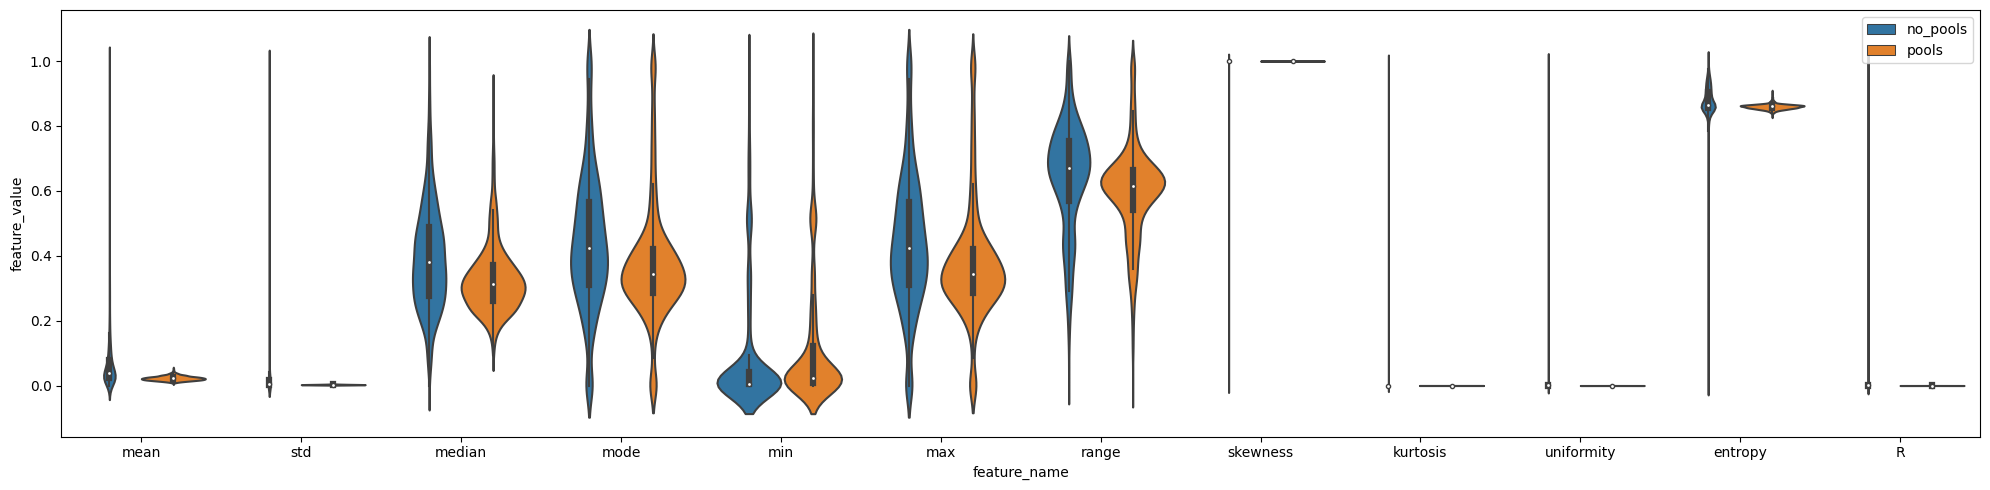

In [128]:
if PLOT_RESULTS:
    plot_features_violinplot(histogram_feature_df)

In [129]:
def plot_feature_df(pixels_df, color='red', secondary_color='blue', width=None, height=None):
    facet_grid = sns.displot(pixels_df, x='feature_value', hue='label', fill=True, palette=[secondary_color, color], kind='kde', col='feature_name')
    facet_grid.fig.set_figwidth(width) if width else None
    facet_grid.fig.set_figheight(height) if height else None
    plt.legend(fontsize=10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

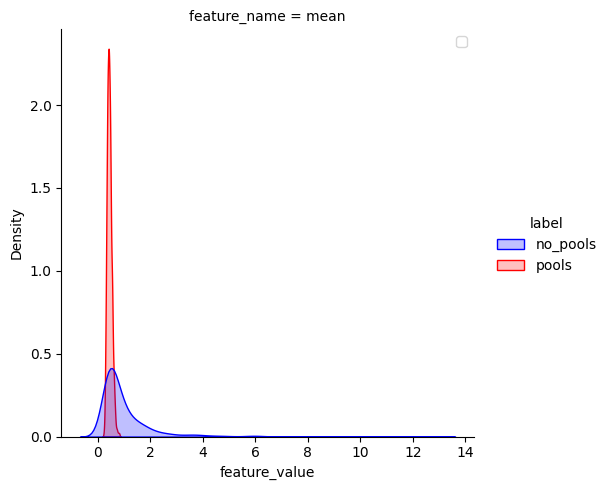

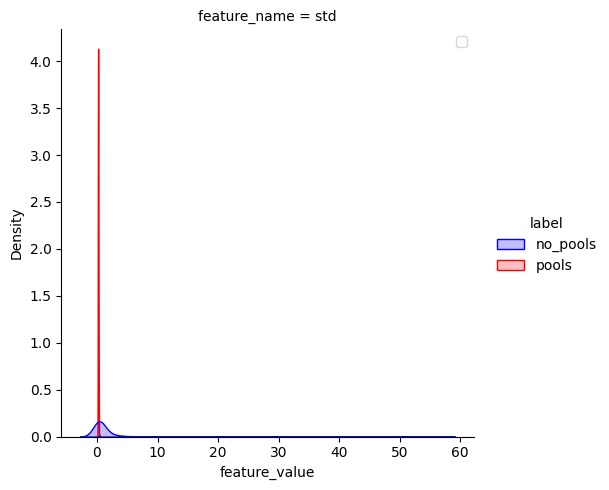

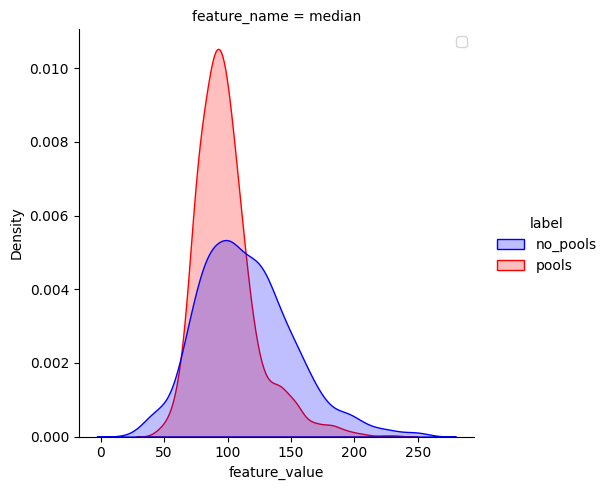

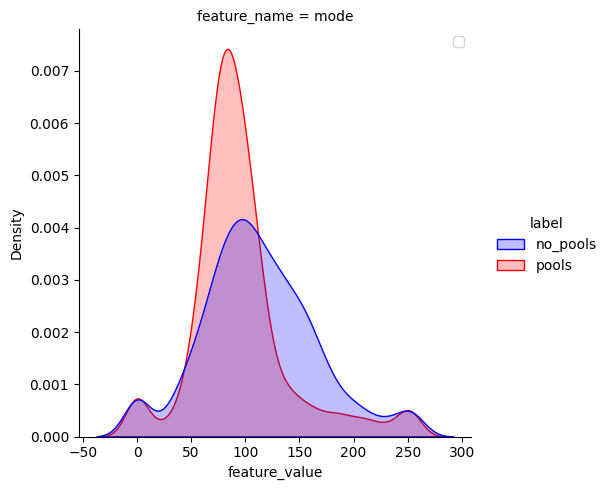

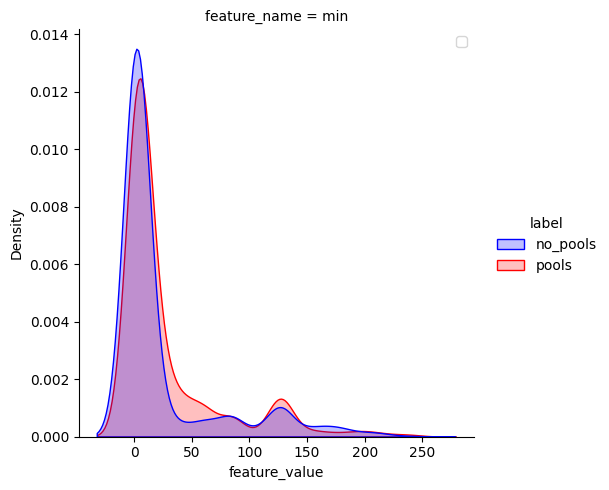

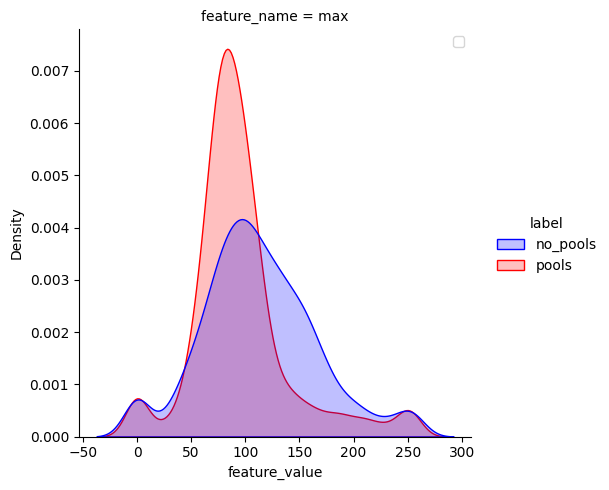

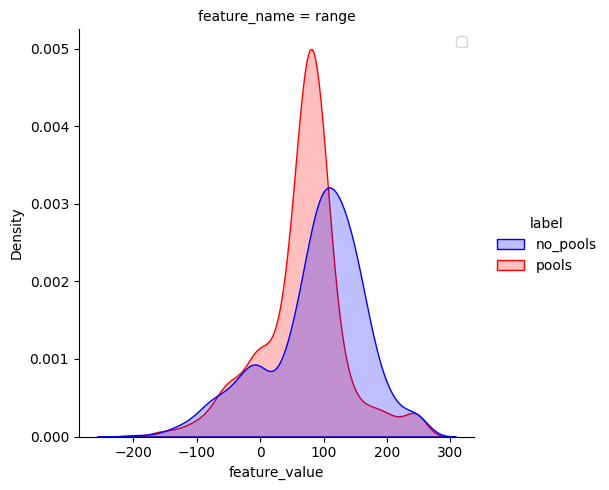

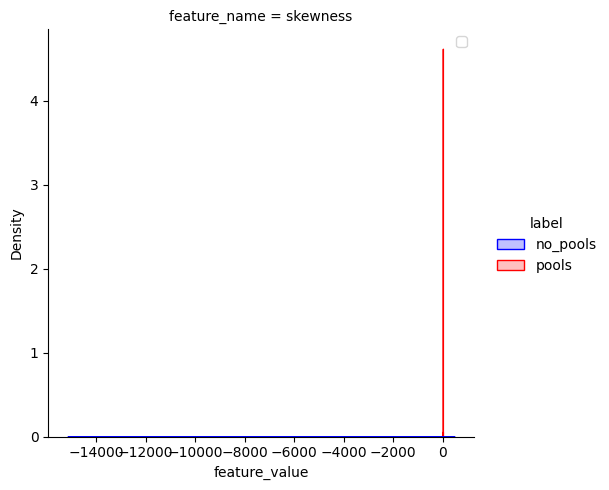

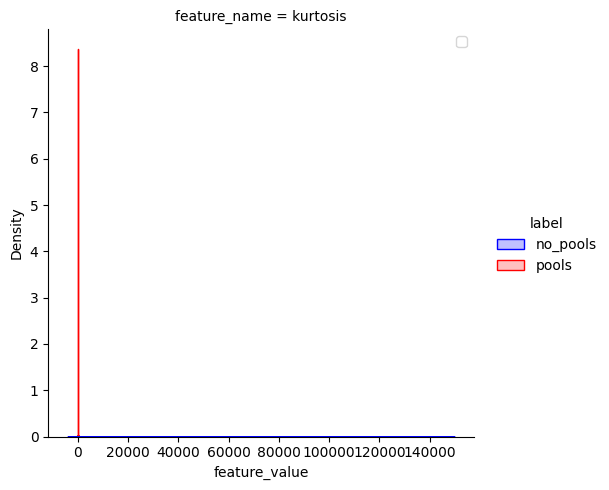

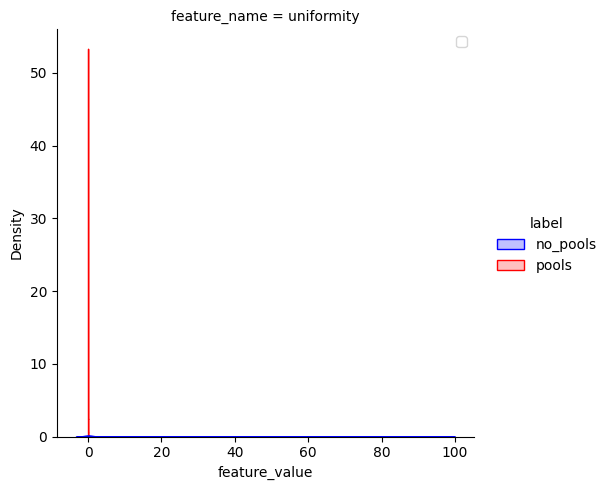

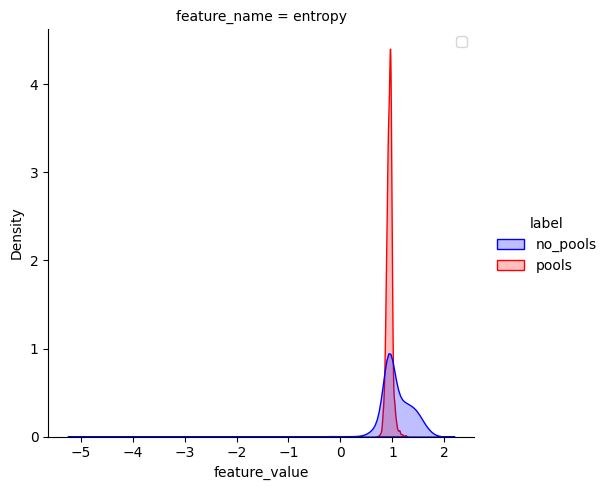

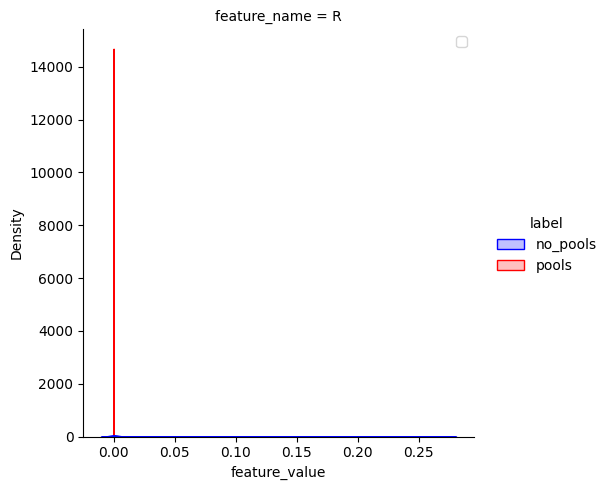

In [130]:
if PLOT_RESULTS:
    for feature_name in model_histogram_feature_functions.keys():
        current_feature_df = histogram_feature_df[histogram_feature_df['feature_name'] == feature_name]
        plot_feature_df(current_feature_df, color='red', secondary_color='blue')

##### **Matriz de correlación**

In [131]:
def create_coocurrence_matrix_df(images: list[tuple], distance, angle, levels=256):
    pixels_df = {'image_id': [], 'feature_name': [], 'feature_value': [], 'label': []}
    grayscale_images = to_grayscale(images)

    for id, image, label in grayscale_images:
        co_occurrence_matrix = graycomatrix(
            image, 
            [distance], 
            [angle], 
            levels=levels, 
            normed=True,
            symmetric=True,
        )

        for feature in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
            pixels_df['image_id'].append(id)
            pixels_df['feature_value'].append(graycoprops(co_occurrence_matrix, feature)[0, 0])
            pixels_df['feature_name'].append(feature)
            pixels_df['label'].append(label)

    df = pd.DataFrame(pixels_df)
    df['feature_value'] = df['feature_value'].astype(float)
    return df

In [132]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'coocurrence_matrix_df.csv')):
    coocurrence_matrix_df = pd.read_csv(os.path.join(FEATURES_DIR, 'coocurrence_matrix_df.csv'))
    dev_coocurrence_matrix_df = pd.read_csv(os.path.join(FEATURES_DIR, 'dev_coocurrence_matrix_df.csv'))
else:
    coocurrence_matrix_df = create_coocurrence_matrix_df(train_images, distance=1, angle=0)
    coocurrence_matrix_df.to_csv(os.path.join(FEATURES_DIR, 'coocurrence_matrix_df.csv'), index=False)
    dev_coocurrence_matrix_df = create_coocurrence_matrix_df(dev_images, distance=1, angle=0)
    dev_coocurrence_matrix_df.to_csv(os.path.join(FEATURES_DIR, 'dev_coocurrence_matrix_df.csv'), index=False)

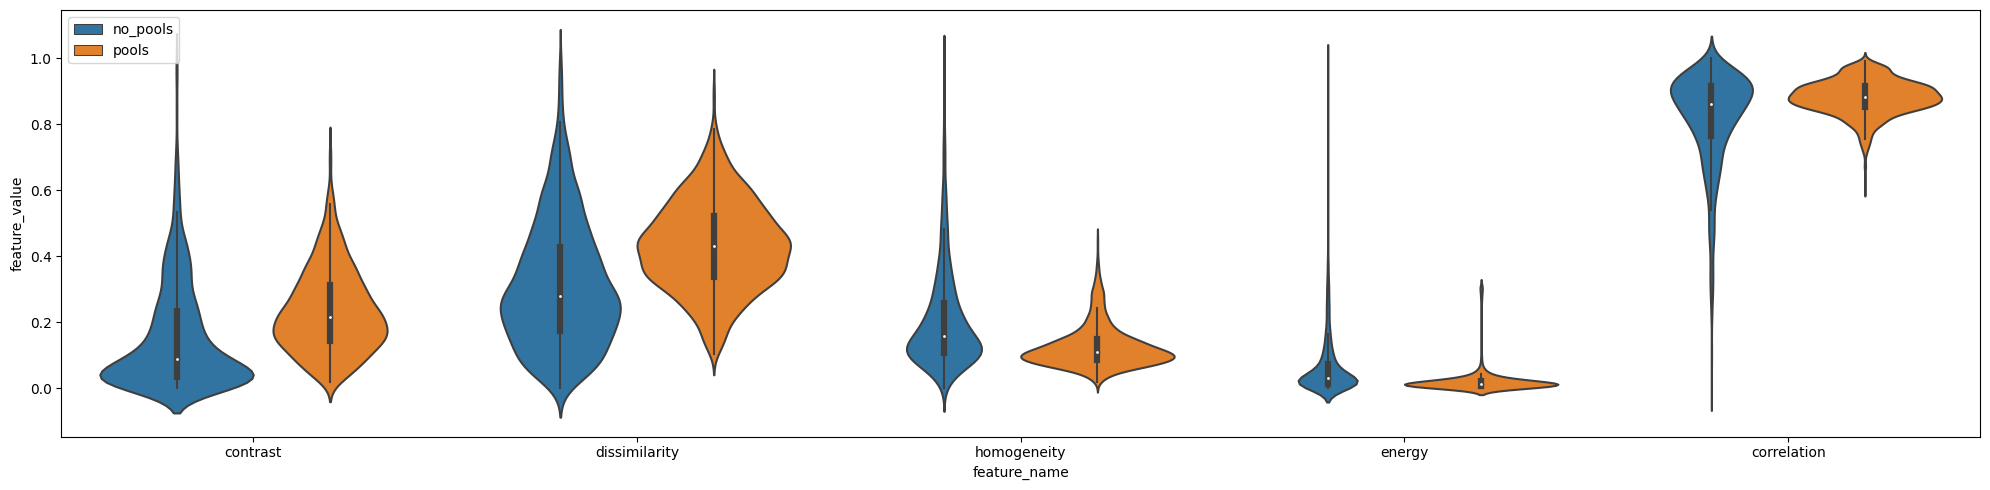

In [133]:
if PLOT_RESULTS:
    plot_features_violinplot(coocurrence_matrix_df)

In [134]:
coocurrence_matrix_df.head()

image_id   feature_name  feature_value     label
0  ..\data\train\no_pools\img508.jpg       contrast      22.060816  no_pools
1  ..\data\train\no_pools\img508.jpg  dissimilarity       3.671429  no_pools
2  ..\data\train\no_pools\img508.jpg    homogeneity       0.239155  no_pools
3  ..\data\train\no_pools\img508.jpg         energy       0.058783  no_pools
4  ..\data\train\no_pools\img508.jpg    correlation       0.686195  no_pools

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


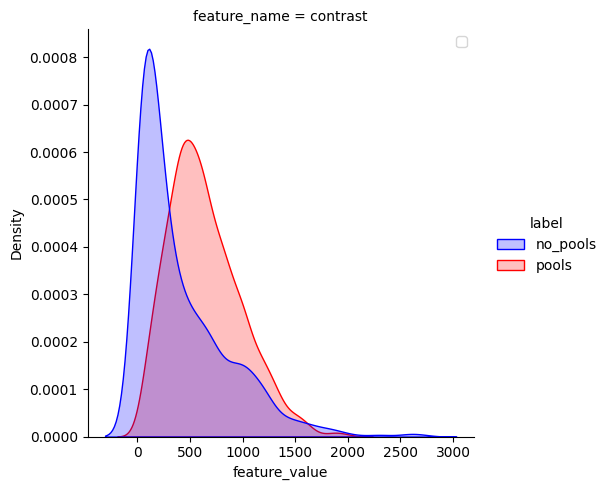

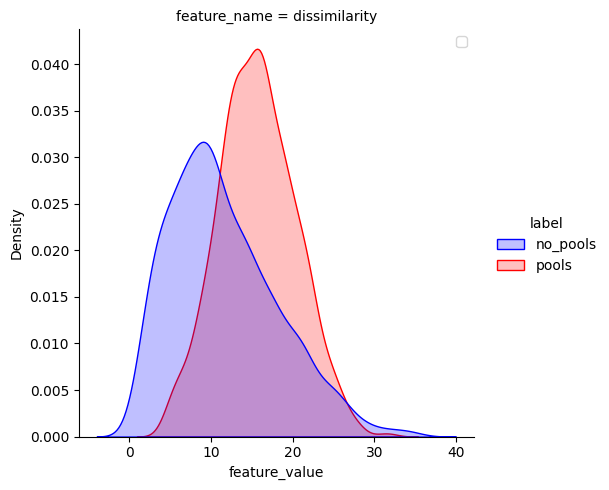

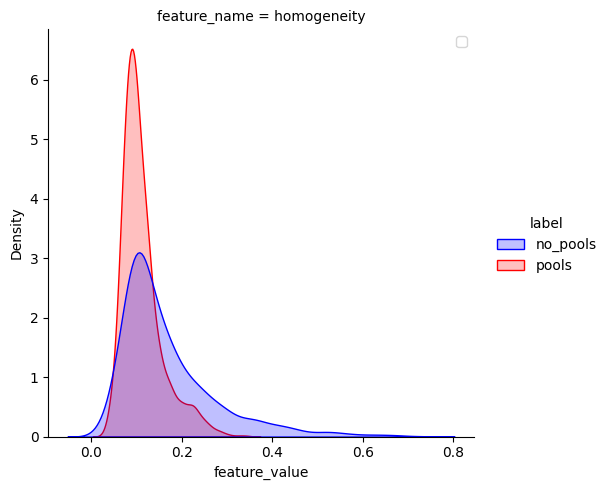

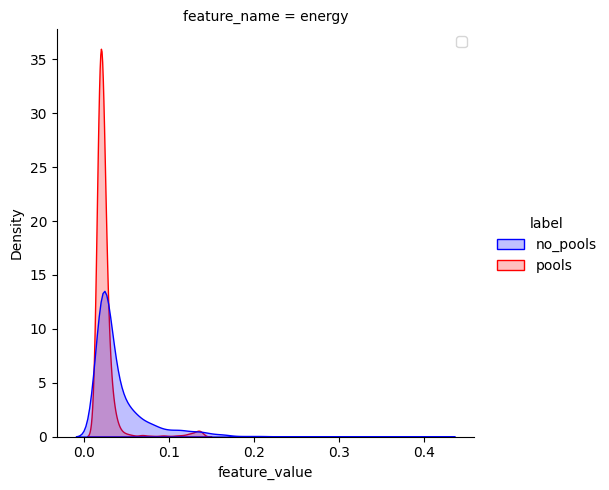

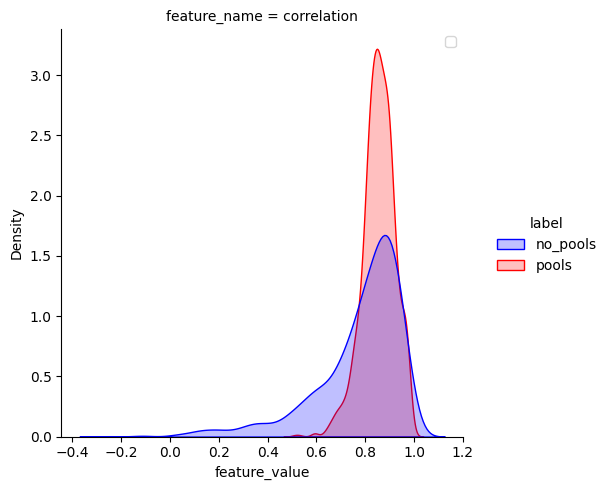

In [135]:
if PLOT_RESULTS:
    for feature_name in coocurrence_matrix_df['feature_name'].unique():
        current_feature_df = coocurrence_matrix_df[coocurrence_matrix_df['feature_name'] == feature_name]
        plot_feature_df(current_feature_df, color='red', secondary_color='blue')

### **Unir features**

In [136]:
def rename_feature(feature_name: str, suffix: str):
    return feature_name + '_' + suffix
    
def ingest_features(color_features: pd.DataFrame, channel_features: pd.DataFrame, histogram_features: pd.DataFrame, coocurrence_matrix_features: pd.DataFrame):
    color_feature_columns = [rename_feature(row['feature_name'], 'color') for _, row in color_features.iterrows()]
    channel_feature_columns = [rename_feature(row['feature_name'], row['channel']) for _, row in channel_features.iterrows()]
    histogram_feature_columns = [rename_feature(row['feature_name'], 'histogram') for _, row in histogram_features.iterrows()]
    coocurrence_matrix_feature_columns = [rename_feature(row['feature_name'], 'coocurrence_matrix') for _, row in coocurrence_matrix_features.iterrows()]
    feature_columns = [*channel_feature_columns, *histogram_feature_columns, *coocurrence_matrix_feature_columns, *color_feature_columns]

    image_initial_features = {**{feature_name: None for feature_name in feature_columns}, 'label': None}
    image_features = {image_id: image_initial_features.copy() for image_id in channel_features['image_id'].unique()}
    ingested_df = {'image_id': [], **{feature_name: [] for feature_name in feature_columns}, 'label': []}
    visited_images = set()

    # Individual datasets
    for _, row in color_features.iterrows():
        image_id = row['image_id']
        renamed_feature = rename_feature(row['feature_name'], 'color')
        feature_value = row['feature_value']
        image_features[image_id][renamed_feature] = feature_value
        if image_id not in visited_images:
            image_features[image_id]['label'] = row['label']
            visited_images.add(image_id)

    for _, row in channel_features.iterrows():
        image_id = row['image_id']
        renamed_feature = rename_feature(row['feature_name'], row['channel'])
        feature_value = row['feature_value']
        image_features[image_id][renamed_feature] = feature_value

    for _, row in histogram_features.iterrows():
        image_id = row['image_id']
        renamed_feature = rename_feature(row['feature_name'], 'histogram')
        feature_value = row['feature_value']
        image_features[image_id][renamed_feature] = feature_value

    for _, row in coocurrence_matrix_features.iterrows():
        image_id = row['image_id']
        renamed_feature = rename_feature(row['feature_name'], 'coocurrence_matrix')
        feature_value = row['feature_value']
        image_features[image_id][renamed_feature] = feature_value

    # Mixed dataset
    for image_id, features in image_features.items():
        for feature_name, feature_values in features.items():
            ingested_df[feature_name].append(feature_values) if feature_name != 'label' else None
        ingested_df['image_id'].append(image_id)
        ingested_df['label'].append(features['label'])


    return pd.DataFrame(ingested_df)

In [137]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'ingested_features_df.csv')):
    ingested_features_df = pd.read_csv(os.path.join(FEATURES_DIR, 'ingested_features_df.csv'))
    dev_ingested_features_df = pd.read_csv(os.path.join(FEATURES_DIR, 'dev_ingested_features_df.csv'))
else:
    ingested_features_df = ingest_features(color_features_df, channel_feature_df, histogram_feature_df, coocurrence_matrix_df)
    ingested_features_df.to_csv(os.path.join(FEATURES_DIR, 'ingested_features_df.csv'), index=False)
    dev_ingested_features_df = ingest_features(dev_color_features_df, dev_channel_feature_df, dev_histogram_feature_df, dev_coocurrence_matrix_df)
    dev_ingested_features_df.to_csv(os.path.join(FEATURES_DIR, 'dev_ingested_features_df.csv'), index=False)

#### **Tests de normalidad**

In [138]:
from scipy.stats import shapiro, anderson, kstest

def shapiro_wilk_test(features: pd.Series):
    _, pvalue = shapiro(features)
    return pvalue

def kolmogorov_smirnov_test(features: pd.Series):
    _, pvalue = kstest(features, 'norm', args=(features.mean(), features.std(ddof=1))) #ddof = 1 para usar desviación estándar muestral
    return pvalue

# The Shapiro–Wilk test is more appropriate method for small sample sizes 
# (<50 samples) although it can also be handling on larger sample size while Kolmogorov–Smirnov test is used for n ≥50.
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6350423/
def create_normality_df(features_df: pd.DataFrame, test='kolmogorov_smirnov'):
    test_functions = {'shapiro_wilk': shapiro_wilk_test, 'kolmogorov_smirnov': kolmogorov_smirnov_test}
    normality_df = {'feature_name': [], 'pvalue': [], 'is_normal': []}
    categorical_features = features_df.select_dtypes(include='object').columns
    for feature_name in features_df.columns:
        if feature_name not in categorical_features:
            pvalue = test_functions[test](features_df[feature_name])
            normality_df['feature_name'].append(feature_name)
            normality_df['pvalue'].append(pvalue)
            normality_df['is_normal'].append(pvalue > 0.05)
    return pd.DataFrame(normality_df)

In [139]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'normality_df.csv')):
    normality_df = pd.read_csv(os.path.join(FEATURES_DIR, 'normality_df.csv'))
else:
    normality_df = create_normality_df(ingested_features_df)
    normality_df.to_csv(os.path.join(FEATURES_DIR, 'normality_df.csv'), index=False)

In [140]:
def plot_normality_df(normality_df: pd.DataFrame, scale='log'):
    _, ax = plt.subplots(figsize=(20, 5))
    sns.barplot(data=normality_df, x='feature_name', y='pvalue', hue='is_normal', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.plot([0, len(normality_df)-1], [0.05, 0.05], linewidth=2, color='red')
    plt.yscale(scale)
    plt.tight_layout()

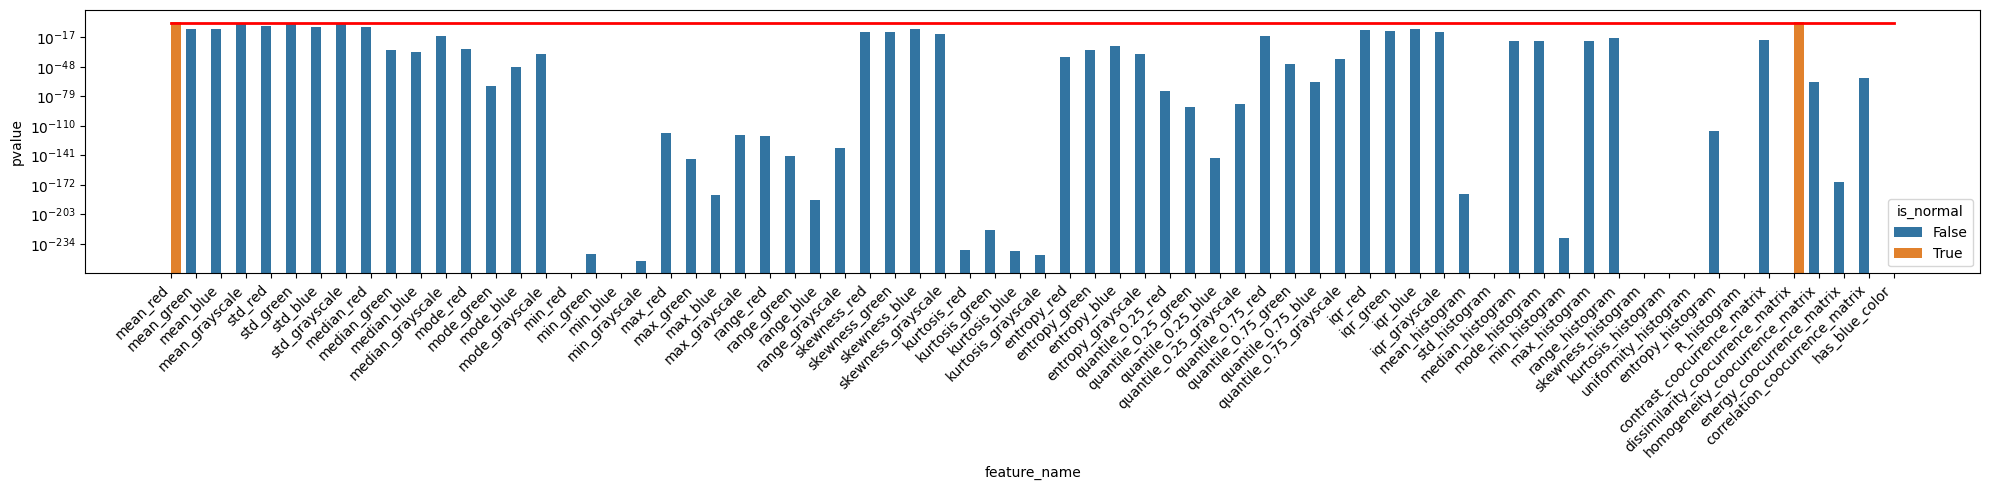

In [141]:
if True:
    plot_normality_df(normality_df)

### **Significancia**

#### **Información mutua**

In [142]:
def create_mutual_info_df(X, y, descriptors):
    mutual_info_statistics = mutual_info_classif(X, y, random_state=0)
    mutual_info_df = pd.DataFrame({'importance': mutual_info_statistics}, index=descriptors)
    mutual_info_df.sort_values(by='importance', ascending=False, inplace=True)
    return mutual_info_df

In [143]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'mutual_info_df.csv')):
    mutual_info_df = pd.read_csv(os.path.join(FEATURES_DIR, 'mutual_info_df.csv'), index_col='feature_name')
else:
    numeric_features = ingested_features_df.select_dtypes(include='number').columns
    X = ingested_features_df[numeric_features]
    y = ingested_features_df['label']
    mutual_info_df = create_mutual_info_df(X, y, numeric_features)
    mutual_info_df.to_csv(os.path.join(FEATURES_DIR, 'mutual_info_df.csv'), index=True, index_label='feature_name')

In [144]:
def plot_mutual_info_df(importances_df: pd.DataFrame):
    _, ax = plt.subplots(figsize=(20, 5))
    sns.barplot(data=importances_df, x=importances_df.index, y='importance', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.tight_layout()

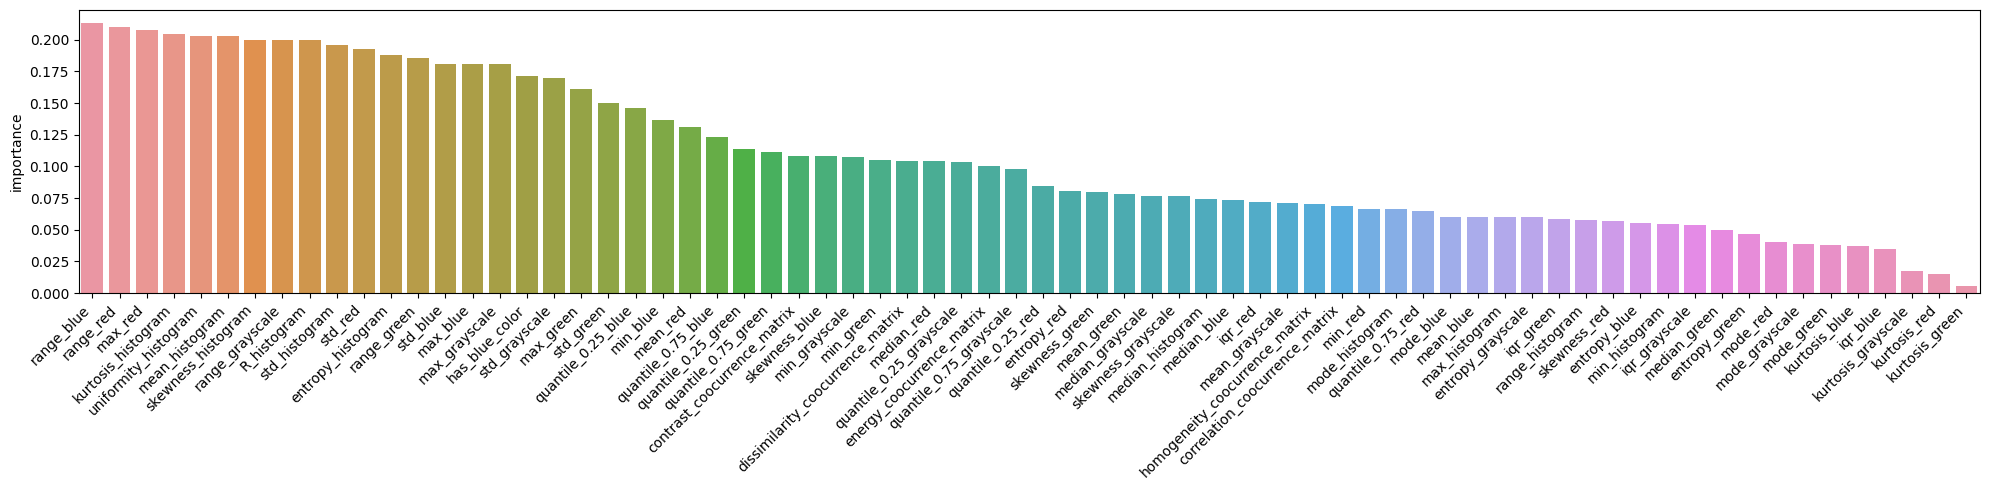

In [145]:
if PLOT_RESULTS:
    plot_mutual_info_df(mutual_info_df)

## **Coeficiente de correlación**

In [146]:
def plot_feature_correlation(feature_df: pd.DataFrame, threshold: float=None, normal=False, plot=True):
    if plot:
        _, ax = plt.subplots(figsize=(15, 15))
    method = 'pearson' if normal else 'spearman' #https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient
    corr = feature_df.corr(numeric_only=True, method=method).abs()
    if threshold:
        corr[corr < threshold] = 0
        corr[corr >= threshold] = 1
    if plot:
        sns.heatmap(corr, annot=False, ax=ax)
    return corr

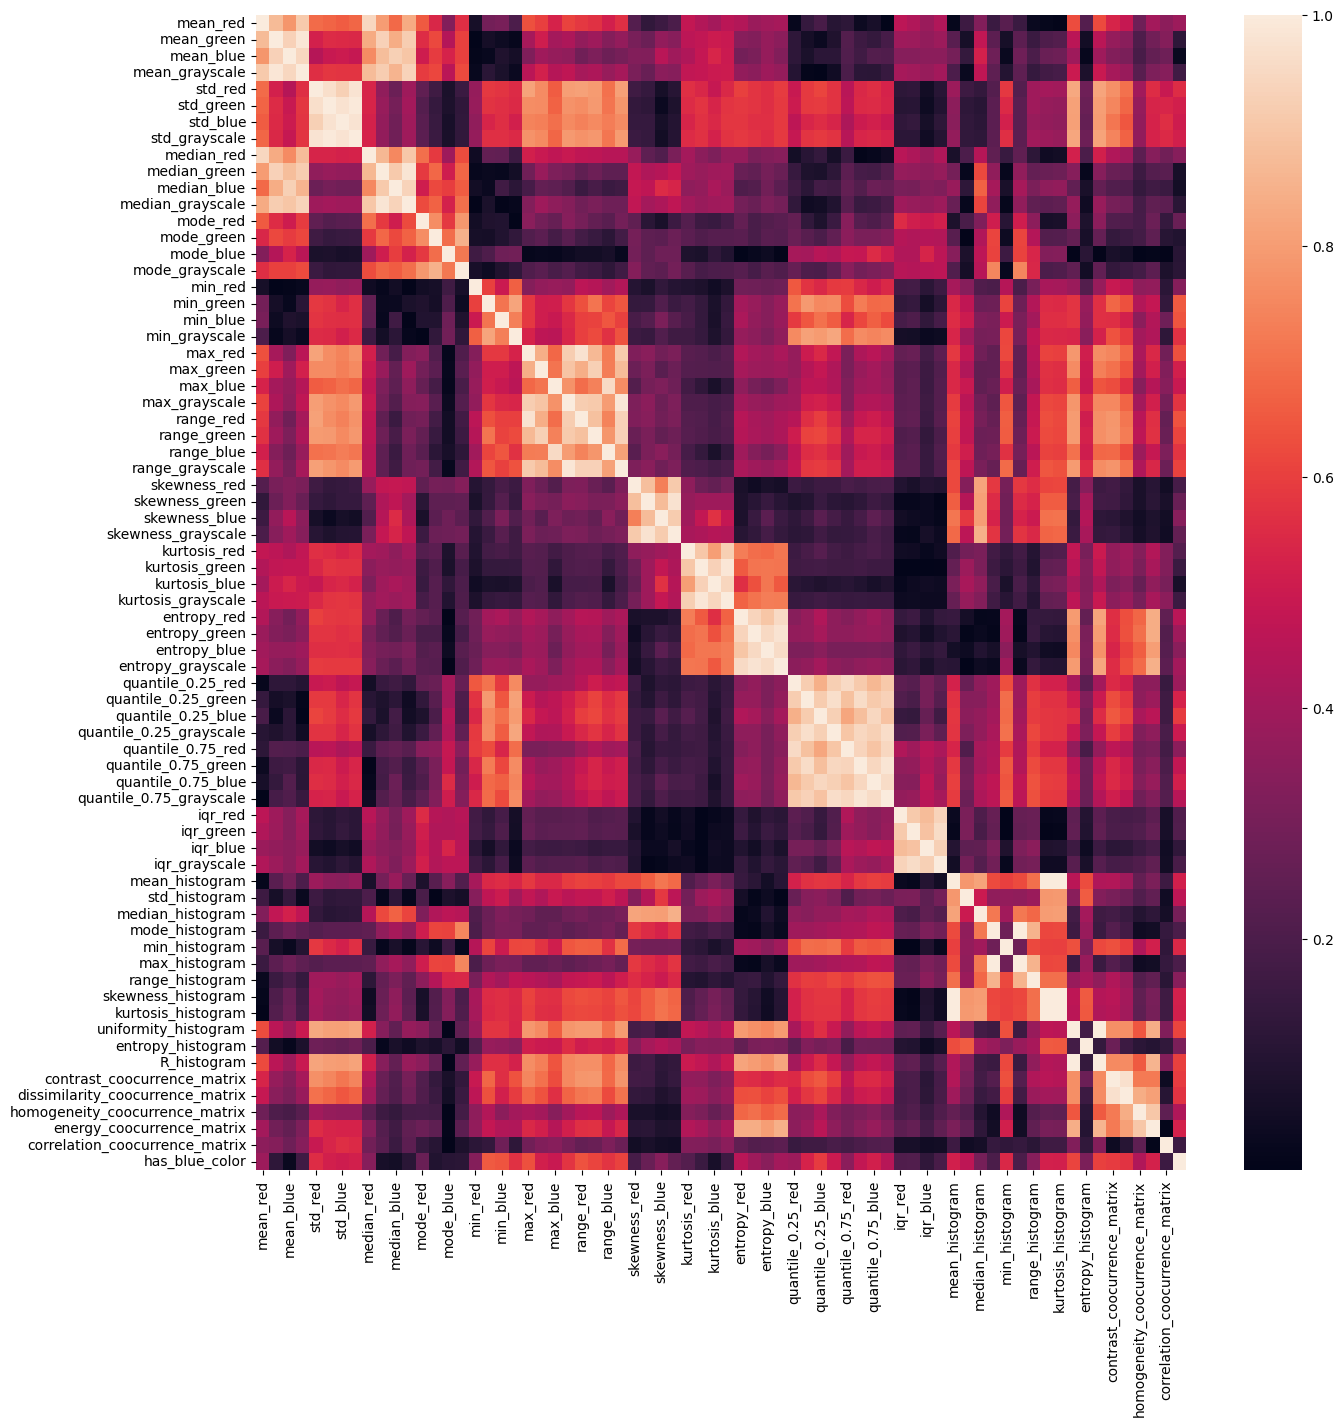

In [147]:
correlated_features = plot_feature_correlation(ingested_features_df, plot=PLOT_RESULTS)

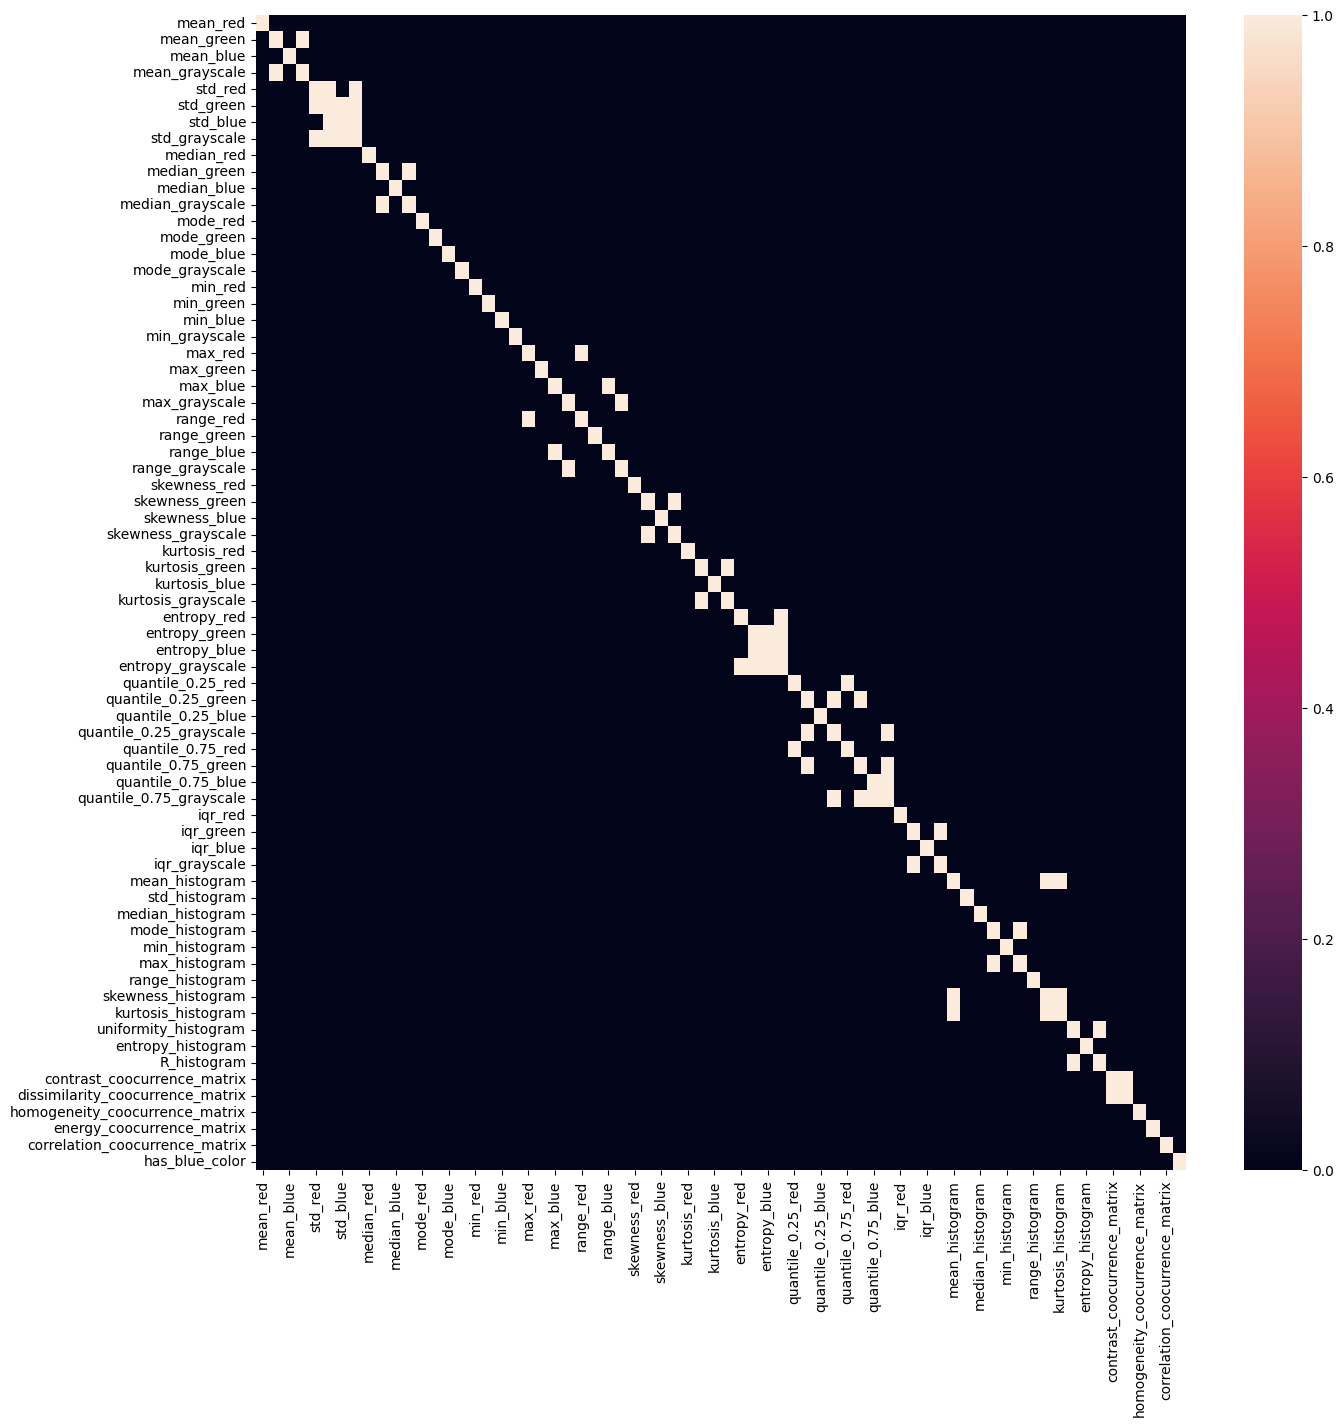

In [148]:
if PLOT_RESULTS:
    plot_feature_correlation(ingested_features_df, threshold=0.95, plot=True)

**Ver features correlacionadas**

In [149]:
CORR_THRESHOLD = 0.95

def get_correlated_features(correlated_features: pd.DataFrame, mutual_info_df: pd.DataFrame, threshold: float=CORR_THRESHOLD, debug=True):
    correlated_features_to_drop = set()
    for name_1 in correlated_features.columns:
        for name_2 in correlated_features.columns:
            if name_1 != name_2:
                if correlated_features[name_1][name_2] > threshold:
                    if (name_1 not in correlated_features_to_drop) and (name_2 not in correlated_features_to_drop):
                        if debug:
                            print(f'Features: {name_1} - {name_2} \n Correlation: {correlated_features[name_1][name_2]:.4f} \n Importance: {mutual_info_df["importance"][name_1]:.4f} - {mutual_info_df["importance"][name_2]:.4f}\n ')
                        if mutual_info_df['importance'][name_1] > mutual_info_df['importance'][name_2]:
                            correlated_features_to_drop.add(name_2)
                        else:
                            correlated_features_to_drop.add(name_1)
    return list(correlated_features_to_drop)

In [150]:
get_correlated_features(correlated_features, mutual_info_df);

Features: mean_green - mean_grayscale 
 Correlation: 0.9862 
 Importance: 0.0780 - 0.0711
 
Features: std_red - std_green 
 Correlation: 0.9664 
 Importance: 0.1929 - 0.1502
 
Features: std_red - std_grayscale 
 Correlation: 0.9766 
 Importance: 0.1929 - 0.1695
 
Features: median_green - median_grayscale 
 Correlation: 0.9830 
 Importance: 0.0500 - 0.0764
 
Features: max_red - range_red 
 Correlation: 0.9757 
 Importance: 0.2080 - 0.2102
 
Features: max_blue - range_blue 
 Correlation: 0.9537 
 Importance: 0.1810 - 0.2129
 
Features: max_grayscale - range_grayscale 
 Correlation: 0.9856 
 Importance: 0.1810 - 0.2001
 
Features: skewness_green - skewness_grayscale 
 Correlation: 0.9765 
 Importance: 0.0798 - 0.0763
 
Features: kurtosis_green - kurtosis_grayscale 
 Correlation: 0.9856 
 Importance: 0.0054 - 0.0176
 
Features: entropy_red - entropy_grayscale 
 Correlation: 0.9554 
 Importance: 0.0803 - 0.0598
 
Features: entropy_green - entropy_blue 
 Correlation: 0.9505 
 Importance: 0.0

In [151]:
with open(os.path.join(FEATURES_DIR, 'correlated_features.txt'), 'w') as f:
    correlated_features_to_drop = get_correlated_features(correlated_features, mutual_info_df, debug=False)
    f.write('\n'.join(correlated_features_to_drop))

#### **Pairplot**

In [152]:
def pairplot_features(feature_df: pd.DataFrame, label: str):
    sns.pairplot(feature_df, hue=label)

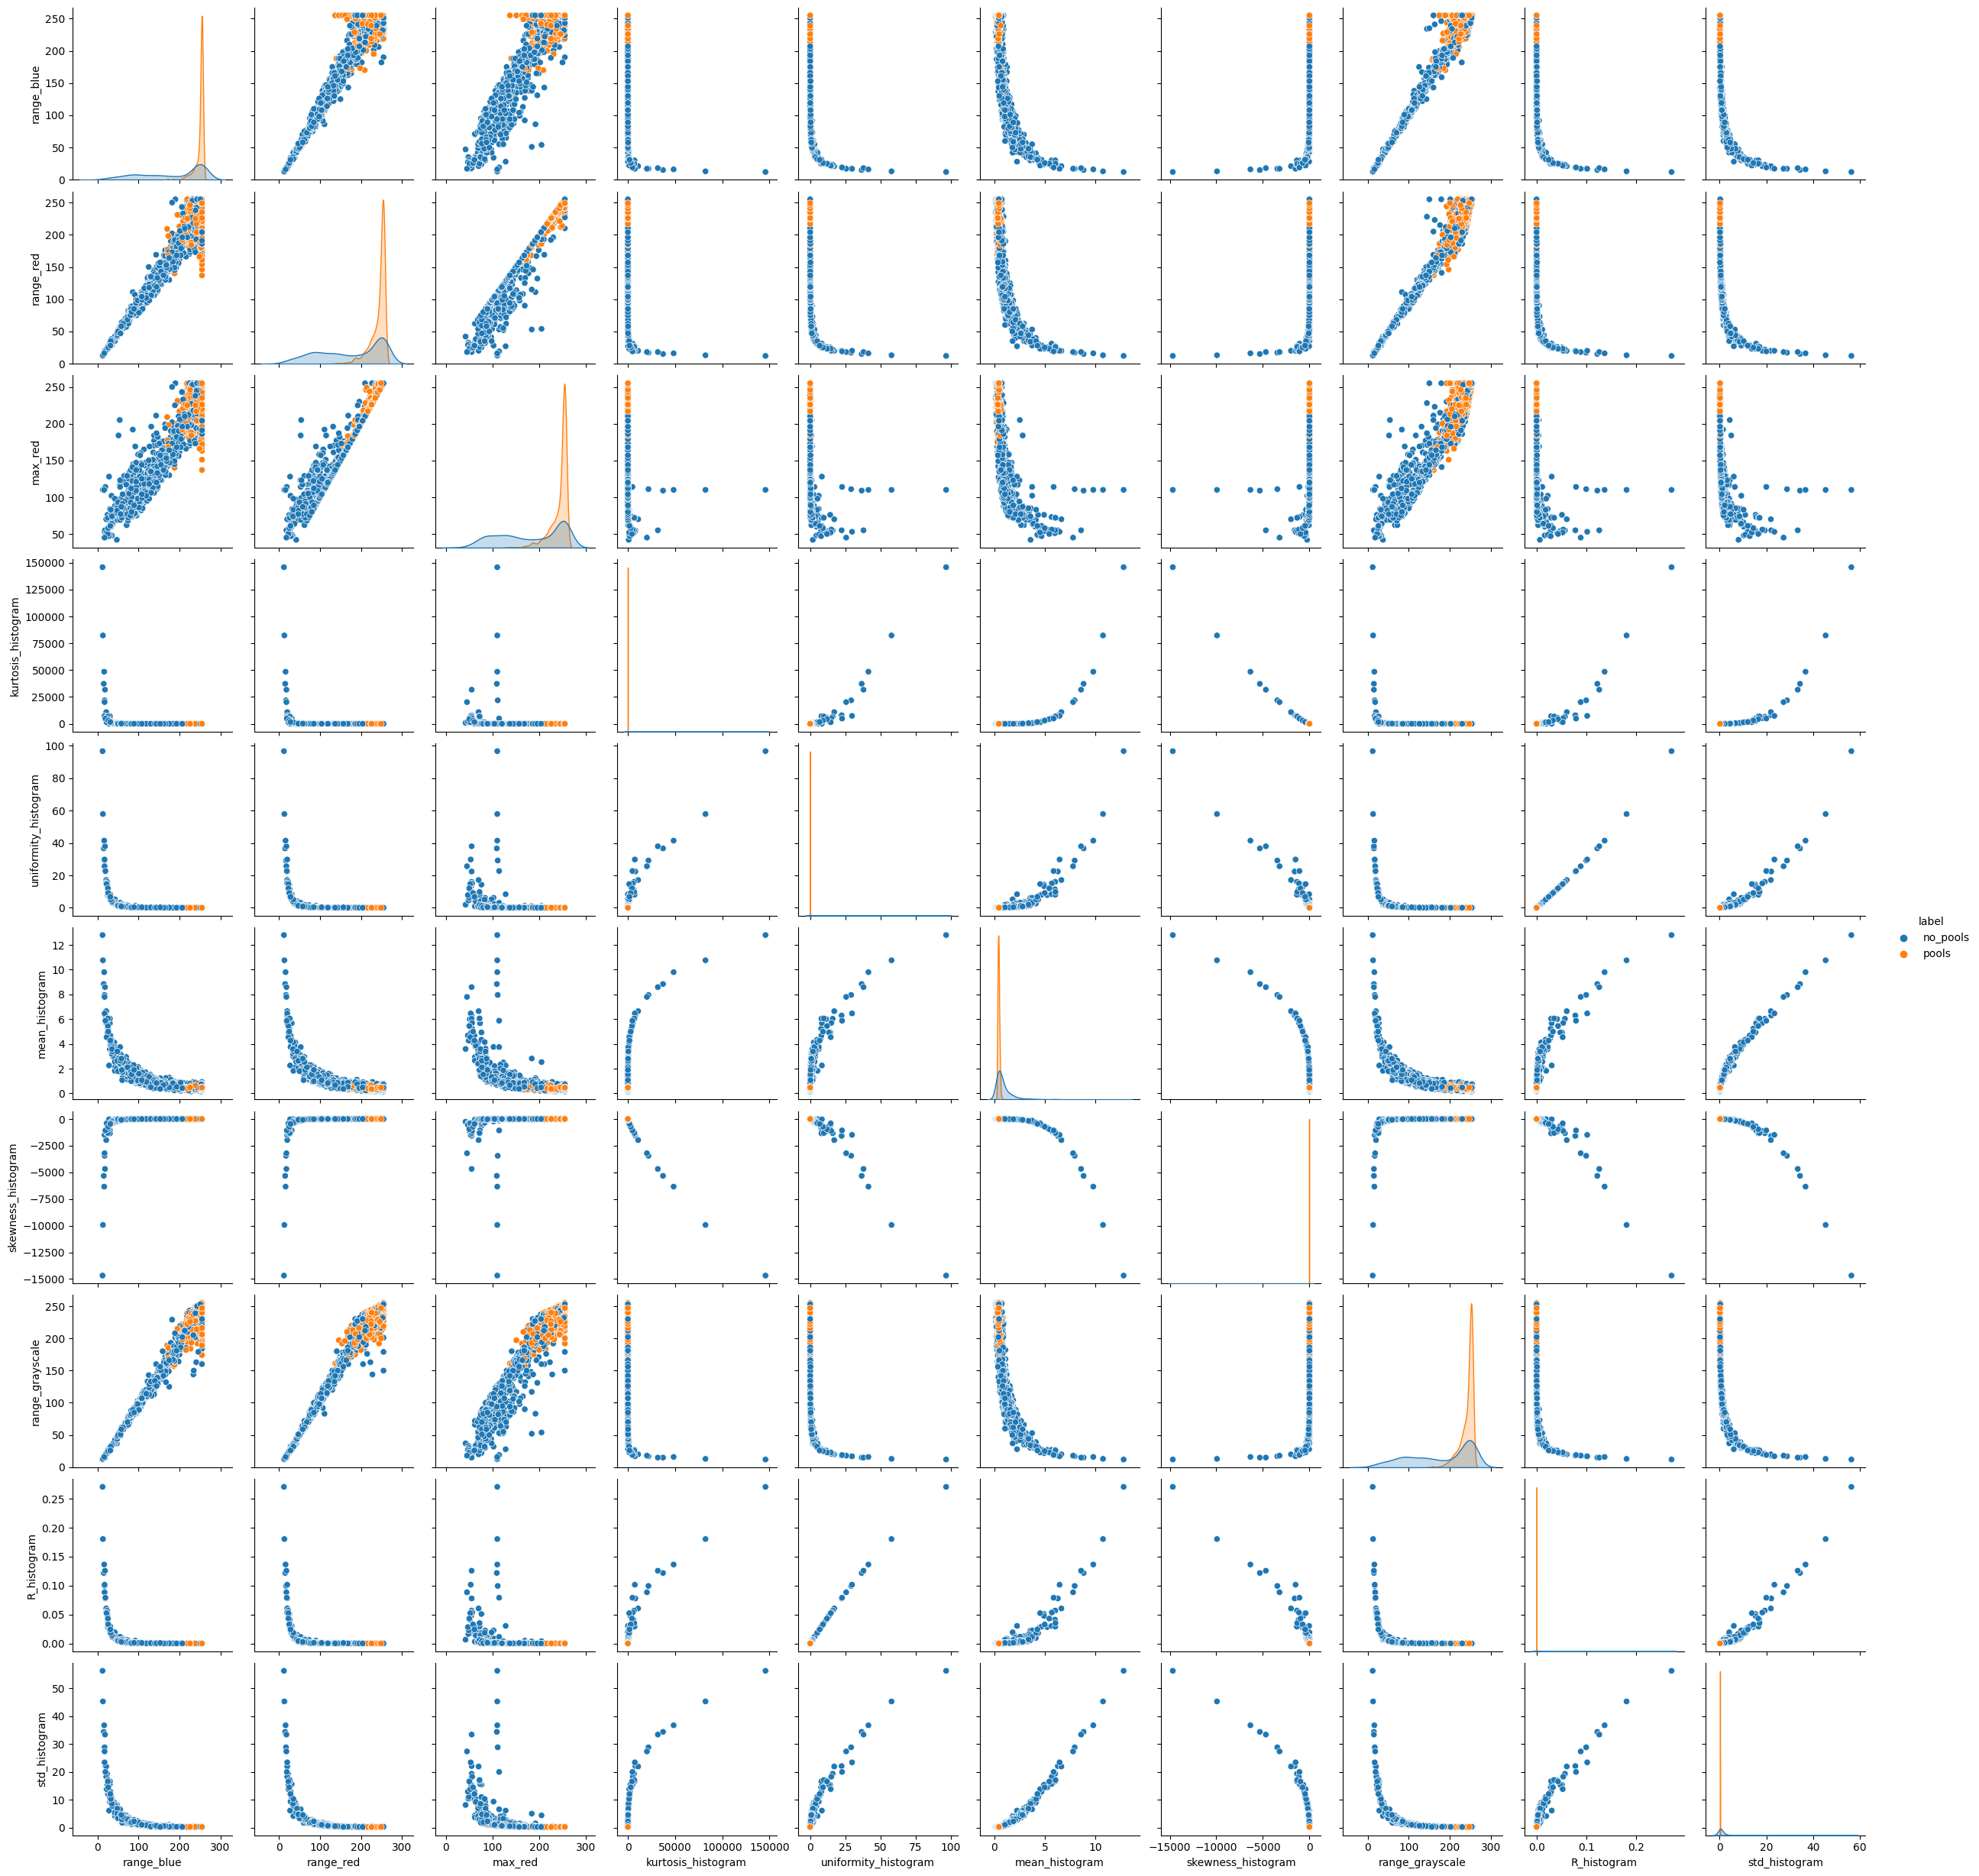

In [153]:
if PLOT_RESULTS:
    top_feature_columns = list(mutual_info_df.index[0:10]) + ['label']
    pairplot_features(ingested_features_df[top_feature_columns], label='label')

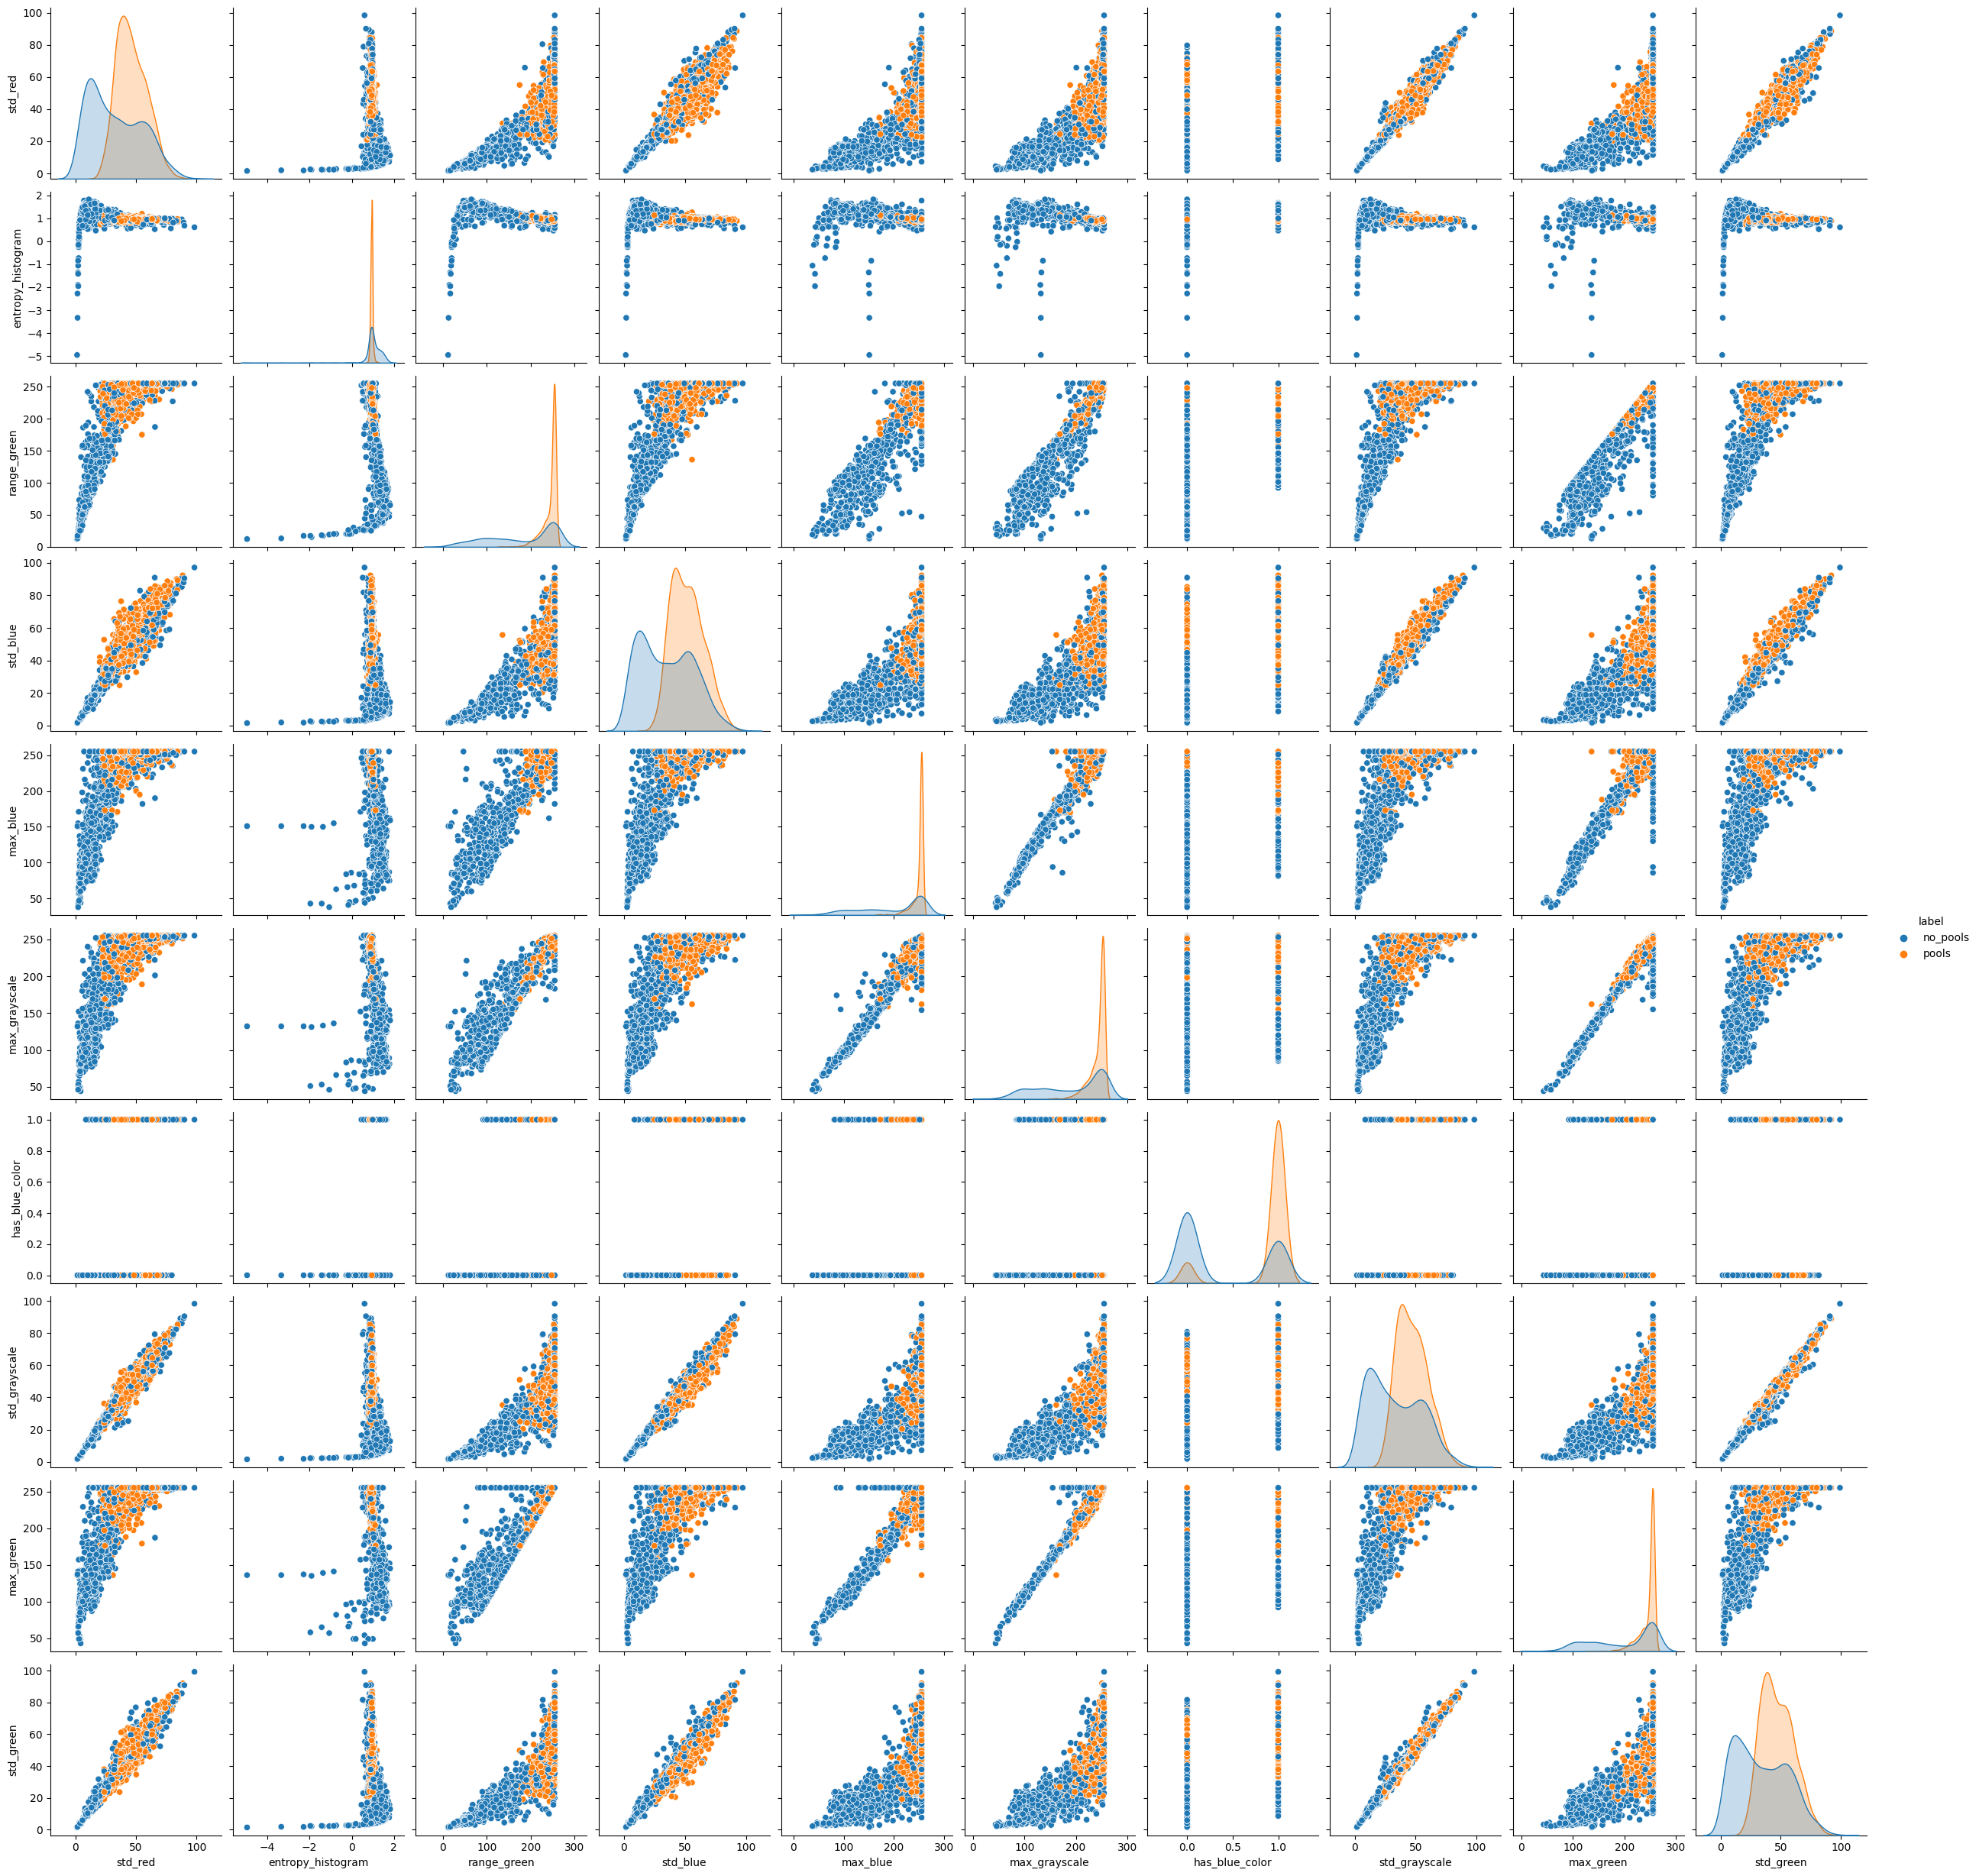

In [154]:
if PLOT_RESULTS:
    out_of_mutual_info_top_feature_columns = list(mutual_info_df.index[10:20]) + ['label']
    pairplot_features(ingested_features_df[out_of_mutual_info_top_feature_columns], label='label')

### **Prueba con clasificadores**

In [155]:
def create_datasets(train_df: pd.DataFrame, dev_df: pd.DataFrame, chosen_columns: list[str], label_column: str):
    train_X = train_df[chosen_columns].drop(columns=[label_column])
    train_y = train_df[label_column]
    dev_X = dev_df[chosen_columns].drop(columns=[label_column])
    dev_y = dev_df[label_column]
    return train_X, train_y, dev_X, dev_y

def create_pipeline(model, scaler=None):
    if scaler:
        return Pipeline([('scaler', scaler), ('model', model)])
    return Pipeline([('model', model)])

def create_model(seed=SEED) -> BaseEstimator:
    return SVC(random_state=seed)

**Nuestro modelo**

In [156]:
print("Cantidad de features:", len(mutual_info_df.index))

Cantidad de features: 70


In [157]:
top_feature_columns = list(mutual_info_df.index[0:]) + ['label']
train_X, train_y, dev_X, dev_y = create_datasets(ingested_features_df, dev_ingested_features_df, top_feature_columns, 'label')

In [158]:
model = create_model()
scaler = StandardScaler()
pipeline = create_pipeline(model, scaler)

In [159]:
pipeline.fit(train_X, train_y)

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC(random_state=2))])

In [160]:
pipeline.score(train_X, train_y), pipeline.score(dev_X, dev_y)

(0.8791390728476821, 0.8990228013029316)